# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

import shap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import resample

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from scipy.stats import t

from joblib import Parallel
from joblib import delayed
from tqdm_joblib import tqdm_joblib

from itertools import combinations

from collections import defaultdict

from tqdm.notebook import tqdm

In [2]:
warnings.filterwarnings("ignore")

np.seterr(all='ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/04a_modeling_lr'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 378)


,$\overline{I}_{3800\text{–}2500}$,$I_{3375}$,$\overline{I}_{3375 \pm 32}$,$I_{3293}$,$\overline{I}_{3293 \pm 32}$,$I_{2928}$,$\overline{I}_{2928 \pm 32}$,$\overline{I}_{1800\text{–}900}$,$\overline{I}_{1800\text{–}1500}$,$I_{1722}$,$\overline{I}_{1722 \pm 32}$,$I_{1626}$,$\overline{I}_{1626 \pm 32}$,$I_{1550}$,$\overline{I}_{1550 \pm 32}$,$\overline{I}_{1500\text{–}1300}$,$I_{1396}$,$\overline{I}_{1396 \pm 32}$,$\overline{I}_{1300\text{–}900}$,$I_{1240}$,$\overline{I}_{1240 \pm 32}$,$I_{1155}$,$\overline{I}_{1155 \pm 32}$,$I_{1074}$,$\overline{I}_{1074 \pm 32}$,...,$\frac{I_{1074}}{\overline{I}_{877 \pm 32}}$,"$\frac{I_{1074}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{1074}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{1074}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{1074}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{\overline{I}_{1074 \pm 32}}{I_{877}}$,$\frac{\overline{I}_{1074 \pm 32}}{\overline{I}_{877 \pm 32}}$,"$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.526201,0.981207,0.975980,1.000000,0.963685,0.491720,0.492079,0.504366,0.537705,0.426530,0.422144,1.0,0.925096,0.421988,0.453781,0.571735,0.760582,0.726142,0.445780,0.452765,0.443662,0.472792,0.479528,0.681294,0.665771,...,13.831119,0.161599,0.368562,0.895754,0.423993,13.648724,13.515977,0.157917,0.360165,0.875345,0.414333,0.011570,0.026388,0.064134,0.030357,0.011684,0.026647,0.064764,0.030655,2.280719,5.543061,2.623735,2.430401,1.150398,0.473337
division_1_size_5,0.477909,1.000000,0.995136,0.925090,0.923226,0.406937,0.401135,0.451487,0.497036,0.387542,0.383206,1.0,0.922786,0.357085,0.390761,0.502368,0.687458,0.656020,0.391974,0.426756,0.423141,0.497397,0.498701,0.606138,0.536587,...,6.322540,0.152973,0.347431,0.881708,0.396093,5.740444,5.597066,0.135421,0.307566,0.780538,0.350644,0.023591,0.053579,0.135972,0.061083,0.024195,0.054951,0.139455,0.062648,2.271189,5.763805,2.589295,2.537792,1.140062,0.449234
division_1_size_3,0.535789,1.000000,0.985816,0.937538,0.935769,0.618445,0.598930,0.517003,0.549005,0.375077,0.381174,1.0,0.938225,0.522055,0.542602,0.523513,0.696553,0.668677,0.489773,0.400246,0.402681,0.683292,0.676252,0.836176,0.731684,...,6.945305,0.185265,0.440758,1.200447,0.435573,6.202150,6.077395,0.162114,0.385679,1.050435,0.381142,0.026138,0.062185,0.169366,0.061453,0.026675,0.063461,0.172843,0.062715,2.379064,6.479617,2.351079,2.723599,0.988237,0.362842


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class']

In [9]:
type_color_dict = {
    '$d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
sns.set_theme()

## Dictionaty for features mapping to type

In [12]:
feature_to_types = defaultdict(list)

for feature_type, features in features_description.items():
    for feature in features:
        feature_to_types[feature].append(feature_type)

## Dictionary for mapping *class* to *size group*

In [13]:
class_fraction_group_dict = {
    0: r'$d \leq 2$',
    1: r'$2 < d \leq 5$',
    2: r'$d > 5$'
}

# Modeling

In [14]:
initial_features_df = features_df.copy()

print(initial_features_df.shape)
initial_features_df.head(3)

(75, 378)


,$\overline{I}_{3800\text{–}2500}$,$I_{3375}$,$\overline{I}_{3375 \pm 32}$,$I_{3293}$,$\overline{I}_{3293 \pm 32}$,$I_{2928}$,$\overline{I}_{2928 \pm 32}$,$\overline{I}_{1800\text{–}900}$,$\overline{I}_{1800\text{–}1500}$,$I_{1722}$,$\overline{I}_{1722 \pm 32}$,$I_{1626}$,$\overline{I}_{1626 \pm 32}$,$I_{1550}$,$\overline{I}_{1550 \pm 32}$,$\overline{I}_{1500\text{–}1300}$,$I_{1396}$,$\overline{I}_{1396 \pm 32}$,$\overline{I}_{1300\text{–}900}$,$I_{1240}$,$\overline{I}_{1240 \pm 32}$,$I_{1155}$,$\overline{I}_{1155 \pm 32}$,$I_{1074}$,$\overline{I}_{1074 \pm 32}$,...,$\frac{I_{1074}}{\overline{I}_{877 \pm 32}}$,"$\frac{I_{1074}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{1074}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{1074}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{1074}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{\overline{I}_{1074 \pm 32}}{I_{877}}$,$\frac{\overline{I}_{1074 \pm 32}}{\overline{I}_{877 \pm 32}}$,"$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1074 \pm 32}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{877}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{877 \pm 32}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.526201,0.981207,0.975980,1.000000,0.963685,0.491720,0.492079,0.504366,0.537705,0.426530,0.422144,1.0,0.925096,0.421988,0.453781,0.571735,0.760582,0.726142,0.445780,0.452765,0.443662,0.472792,0.479528,0.681294,0.665771,...,13.831119,0.161599,0.368562,0.895754,0.423993,13.648724,13.515977,0.157917,0.360165,0.875345,0.414333,0.011570,0.026388,0.064134,0.030357,0.011684,0.026647,0.064764,0.030655,2.280719,5.543061,2.623735,2.430401,1.150398,0.473337
division_1_size_5,0.477909,1.000000,0.995136,0.925090,0.923226,0.406937,0.401135,0.451487,0.497036,0.387542,0.383206,1.0,0.922786,0.357085,0.390761,0.502368,0.687458,0.656020,0.391974,0.426756,0.423141,0.497397,0.498701,0.606138,0.536587,...,6.322540,0.152973,0.347431,0.881708,0.396093,5.740444,5.597066,0.135421,0.307566,0.780538,0.350644,0.023591,0.053579,0.135972,0.061083,0.024195,0.054951,0.139455,0.062648,2.271189,5.763805,2.589295,2.537792,1.140062,0.449234
division_1_size_3,0.535789,1.000000,0.985816,0.937538,0.935769,0.618445,0.598930,0.517003,0.549005,0.375077,0.381174,1.0,0.938225,0.522055,0.542602,0.523513,0.696553,0.668677,0.489773,0.400246,0.402681,0.683292,0.676252,0.836176,0.731684,...,6.945305,0.185265,0.440758,1.200447,0.435573,6.202150,6.077395,0.162114,0.385679,1.050435,0.381142,0.026138,0.062185,0.169366,0.061453,0.026675,0.063461,0.172843,0.062715,2.379064,6.479617,2.351079,2.723599,0.988237,0.362842


## Target rate analysis

Mapping hue ~ group:
* Class 0 — $0< d \leq 2$
* Class 1 — $2 < d \leq 5$
* Class 2 — $d > 5$

In [15]:
fractions_hue_df = pd.DataFrame(samples_description['Fraction_hue'].value_counts()).sort_values(by='Fraction_hue')

fractions_hue_df.T

Fraction_hue,$< 0.2$,$< 0.4$,$< 2$,$< 2.5$,$< 25$,$< 3$,$< 4$,$< 5$,$< 50$,$< 70$,$< 75$,$> 0$
count,7,8,8,8,6,10,1,10,1,3,3,10


In [16]:
target_rate_df = pd.DataFrame(samples_description['Fraction_grouped_hue'].value_counts()).sort_values(by='Fraction_grouped_hue')

target_rate_df.T

Fraction_grouped_hue,$2 < d \leq 5$,$d > 5$,$d \leq 2$
count,29,23,23


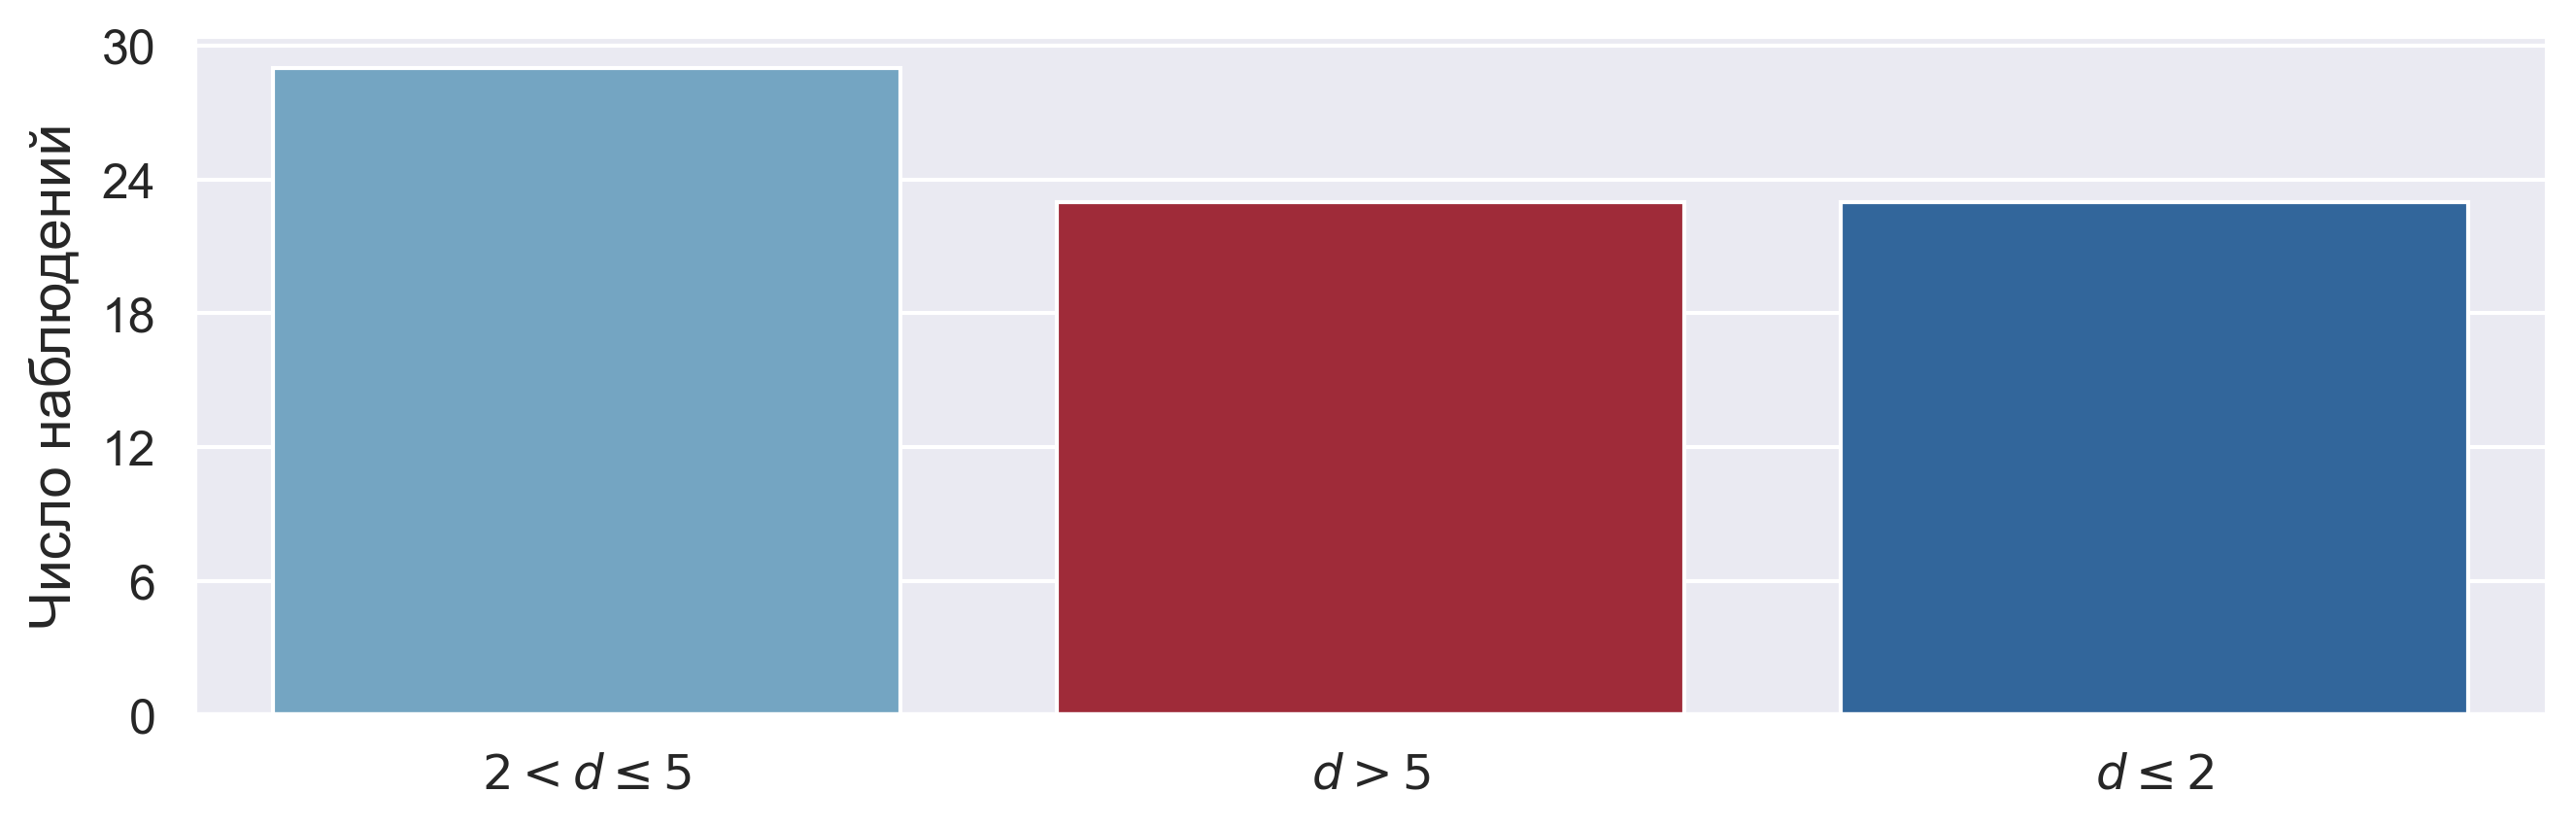

In [17]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

sns.barplot(
    data=target_rate_df,
    x='Fraction_grouped_hue',
    y='count',
    palette=type_color_dict,
    ax=ax
)

ax.set_xlabel('', fontsize=14, labelpad=5)
ax.set_ylabel('Число наблюдений', fontsize=14, labelpad=5)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()

plt.savefig(f'{path_to_save}/target_rate_barplot.png', dpi=600)

plt.show()

## *One-factor* analysis

### Calculation process

In [18]:
def of_analysis(feature, features_df, target, n_bootstrap=50, C=1.0):
    rng = np.random.default_rng(42)

    X_raw = features_df[[feature]].values
    y = target.values

    # --- Global model ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    mean_val, std_val = scaler.mean_[0], scaler.scale_[0]

    estimator = OneVsRestClassifier(LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=10_000, random_state=42))
    estimator.fit(X_scaled, y)

    try:
        y_score = estimator.predict_proba(X_scaled)
        metric_ovr = roc_auc_score(y, y_score, multi_class='ovr')
    except ValueError:
        metric_ovr = np.nan

    # --- Bootstrap with real data ---
    bs_scores = []

    for seed in range(n_bootstrap):
        X_bs, y_bs = resample(X_raw, y, replace=True, random_state=seed)
        X_bs_scaled = StandardScaler().fit_transform(X_bs)
        model = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42))
        try:
            model.fit(X_bs_scaled, y_bs)
            y_pred = model.predict_proba(X_bs_scaled)
            score = roc_auc_score(y_bs, y_pred, multi_class='ovr')
        except ValueError:
            score = np.nan
        bs_scores.append(score)

    bs_scores = np.array(bs_scores)
    bs_mean = np.nanmean(bs_scores)
    ci_5 = np.nanpercentile(bs_scores, 5)
    ci_95 = np.nanpercentile(bs_scores, 95)

    # --- Bootstrap with shuffled (noise) data ---
    shuffled = rng.permutation(X_raw.ravel()).reshape(-1, 1)
    bs_noise_scores = []

    for seed in range(n_bootstrap):
        X_noise_bs, y_noise_bs = resample(shuffled, y, replace=True, random_state=seed)
        X_noise_scaled = StandardScaler().fit_transform(X_noise_bs)
        model = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42))
        try:
            model.fit(X_noise_scaled, y_noise_bs)
            y_pred_noise = model.predict_proba(X_noise_scaled)
            score = roc_auc_score(y_noise_bs, y_pred_noise, multi_class='ovr')
        except ValueError:
            score = np.nan
        bs_noise_scores.append(score)

    noise_mean = np.nanmean(bs_noise_scores)
    delta_auc = bs_mean - noise_mean
    z_score = delta_auc / np.nanstd(bs_noise_scores) if np.nanstd(bs_noise_scores) > 0 else np.nan

    return {
        'Feature': feature,
        '$scale-mean$': mean_val,
        '$scale-std$': std_val,
        '$C$': C,
        '$ROC-AUC_{ovr}$': metric_ovr,
        '$ROC-AUC_{ovr}^{BS}$': bs_mean,
        '$CI_{5\%}$': ci_5,
        '$CI_{95\%}$': ci_95,
        '$ROC-AUC_{ovr}^{noise}$': noise_mean,
        '$ΔROC-AUC$': delta_auc,
        '$z-score$': z_score
    }


In [19]:
features_list = features_df.columns.tolist()

with tqdm_joblib(desc='Calculation progress', total=len(features_list)):
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(of_analysis)(
            feature,
            features_df,
            target,
            n_bootstrap=50
        )
        for feature in features_list
    )

Calculation progress:   0%|          | 0/378 [00:00<?, ?it/s]

In [20]:
of_metrics_df = pd.DataFrame(results)

of_metrics_df = of_metrics_df.sort_values(by=['$ROC-AUC_{ovr}^{BS}$', '$ΔROC-AUC$'], ascending=[False, False])

print(of_metrics_df.shape)
of_metrics_df.head(3)

(378, 11)


,Feature,$scale-mean$,$scale-std$,$C$,$ROC-AUC_{ovr}$,$ROC-AUC_{ovr}^{BS}$,$CI_{5\%}$,$CI_{95\%}$,$ROC-AUC_{ovr}^{noise}$,$ΔROC-AUC$,$z-score$
104,$\frac{I_{3375}}{I_{2928}}$,1.174717,0.873880,1.0,0.866970,0.861777,0.800385,0.917450,0.619991,0.241786,5.026097
109,$\frac{\overline{I}_{3375 \pm 32}}{I_{2928}}$,1.165387,0.865226,1.0,0.866442,0.860906,0.801459,0.916024,0.621565,0.239341,4.898911
111,"$\frac{\overline{I}_{3375 \pm 32}}{\Sigma I_{p,\ 3800\text{–}2500}}$",0.304048,0.100356,1.0,0.864462,0.858787,0.810707,0.912697,0.617865,0.240922,4.699526


### Mapping features with their types

In [21]:
rows = []

for _, row in of_metrics_df.iterrows():
    feature = row['Feature']
    feature_types = feature_to_types.get(feature, [])

    for feature_type in feature_types:
        row_copy = row.copy()
        row_copy['Feature_Type'] = feature_type
        rows.append(row_copy)

of_metrics_expanded_df = pd.DataFrame(rows)

print(of_metrics_expanded_df.shape)
of_metrics_expanded_df.head(3)

(756, 12)


,Feature,$scale-mean$,$scale-std$,$C$,$ROC-AUC_{ovr}$,$ROC-AUC_{ovr}^{BS}$,$CI_{5\%}$,$CI_{95\%}$,$ROC-AUC_{ovr}^{noise}$,$ΔROC-AUC$,$z-score$,Feature_Type
104,$\frac{I_{3375}}{I_{2928}}$,1.174717,0.873880,1.0,0.866970,0.861777,0.800385,0.917450,0.619991,0.241786,5.026097,engineered_features_peaks_3800_2500
104,$\frac{I_{3375}}{I_{2928}}$,1.174717,0.873880,1.0,0.866970,0.861777,0.800385,0.917450,0.619991,0.241786,5.026097,engineered_features
109,$\frac{\overline{I}_{3375 \pm 32}}{I_{2928}}$,1.165387,0.865226,1.0,0.866442,0.860906,0.801459,0.916024,0.621565,0.239341,4.898911,engineered_features_intervals_3800_2500


### Visualization

In [22]:
feature_types = [
    'base_features_peaks_3800_2500',
    'base_features_intervals_3800_2500',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2500',
    'engineered_features_intervals_3800_2500',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [23]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 8,
    'X_NBINS': 8,
    'BAR_WIDTH': 0.7,
    'BAR_ALPHA': 0.85,
    'FIG_DPI': 300,
    'SUBPLOT_WIDTH': 5,
    'SUBPLOT_HEIGHT': 4,
    'TOP_N': 5,
    'COLOR_MAP': {
        'base': 'royalblue',
        'engineered': 'seagreen'
    },
    'LEGEND_FONT_SIZE': 12
}

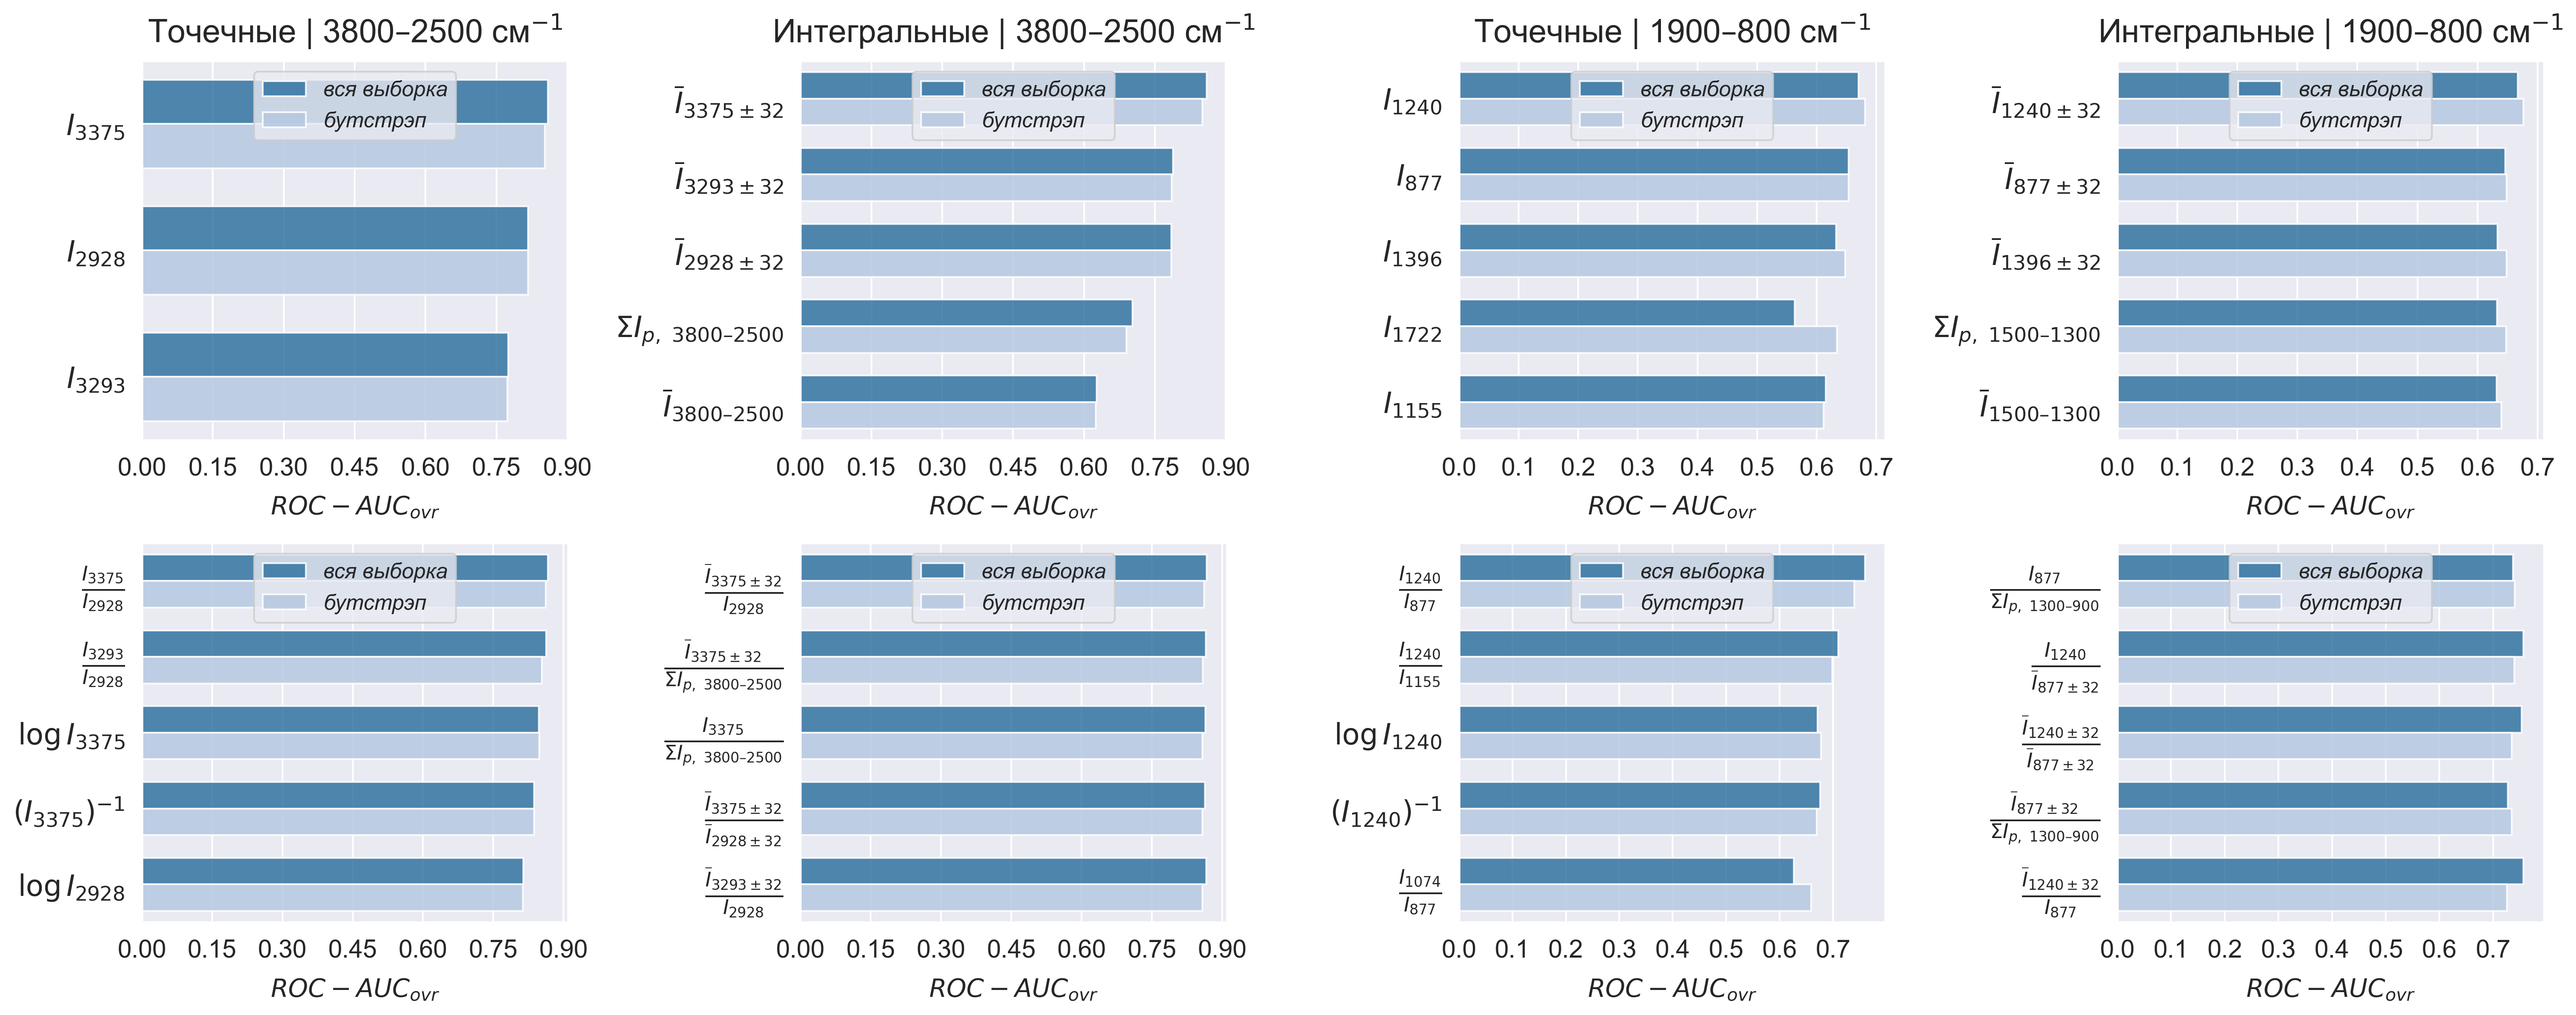

In [24]:
nrows, ncols = 2, 4

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * PLOT_STYLE['SUBPLOT_WIDTH'], nrows * PLOT_STYLE['SUBPLOT_HEIGHT']),
    dpi=PLOT_STYLE['FIG_DPI']
)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    subset = of_metrics_expanded_df[of_metrics_expanded_df['Feature_Type'] == feature_type]
    
    result_df = (
        subset
        .sort_values(
            by=['$ROC-AUC_{ovr}^{BS}$', '$ROC-AUC_{ovr}$'],
            ascending=[False, False]
        )
        .head(PLOT_STYLE['TOP_N'])
        .copy()
    )

    result_df = result_df[['Feature', '$ROC-AUC_{ovr}$', '$ROC-AUC_{ovr}^{BS}$']]
    
    result_df = result_df.melt(id_vars='Feature', var_name='Type', value_name='ROC-AUC')
    result_df['Type'] = result_df['Type'].map({
        '$ROC-AUC_{ovr}$': 'вся выборка',
        '$ROC-AUC_{ovr}^{BS}$': 'бутстрэп'
    })

    kind = 'engineered' if 'engineered' in feature_type else 'base'
    color = PLOT_STYLE['COLOR_MAP'][kind]

    ax = axes[i]
    
    sns.barplot(
        data=result_df,
        x='ROC-AUC',
        y='Feature',
        hue='Type',
        ax=ax,
        palette=['#1f77b4', '#aec7e8'],
        width=PLOT_STYLE['BAR_WIDTH'],
        alpha=PLOT_STYLE['BAR_ALPHA']
    )

    if i < 4:
        label = 'Точечные' if 'peaks' in feature_type else 'Интегральные'
        a, b = [s for s in feature_type.split('_') if s.isdigit()][-2:]
        title = f'{label} | {a}–{b} см$^{{-1}}$'
        
        ax.set_title(
            title,
            fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
            fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
            pad=10
        )

    ax.set_xlabel('$ROC-AUC_{ovr}$', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    legend = ax.legend(loc='upper center', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'], frameon=True)
    for text in legend.get_texts():
        text.set_fontstyle('italic')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# plt.savefig(f'{path_to_save}/roc_auc_barplots.png', dpi=600)

plt.show()

### *Hard-check* factor selection

In [25]:
of_features_to_save = (
    of_metrics_df
    .loc[
        (of_metrics_df['$ROC-AUC_{ovr}$'] >= 0.60)
        # & (of_metrics_df['$ROC-AUC_{ovr}^{BS}$'] >= 0.60)
        & (of_metrics_df['$CI_{5\%}$'] >= 0.60)
        & (of_metrics_df['$ΔROC-AUC$'] > 0.10)
    ]['Feature']
).tolist()

print(
    f'Число фичей',
    f'(*) до отбора: {len(of_metrics_df["Feature"].unique())}',
    f'(*) после отбора: {len(of_features_to_save)}',
    f'Доля фичей, прошедших однофакторный отбор: {round(len(of_features_to_save) / len(of_metrics_df["Feature"].unique()) * 100, 2)}%',
    sep='\n'
)

Число фичей
(*) до отбора: 378
(*) после отбора: 65
Доля фичей, прошедших однофакторный отбор: 17.2%


## *Multi-factor* analysis

### Functions for processing & config-parameters

In [26]:
PLOT_STYLE = {
    'TITLE': '',
    'TITLE_FONT_SIZE': 12,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 16,
    'Y_TICK_LABEL_FONT_SIZE': 10,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'METRIC_VALUE_FONT_SIZE': 8,
    'Y_NBINS': 10
}

#### Forward selection

In [27]:
def forward_selection_bootstrap(features_df, target, candidate_features, scoring='roc_auc_ovr',
                                 min_uplift=None, max_features=None, n_bootstrap=50, n_jobs=-1,
                                 use_tqdm=True, uplift_type='mean', return_ci=True):
    selected, best_score, history = [], -np.inf, []
    remain = candidate_features.copy()

    def bootstrap_score(feature_set):
        X = features_df[feature_set].values
        y = target.values

        def single_bootstrap(seed):
            X_bs, y_bs = resample(X, y, replace=True, random_state=seed)
            estimator = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', OneVsRestClassifier(LogisticRegression(max_iter=10000, C=1.0, random_state=42)))
            ])
            try:
                estimator.fit(X_bs, y_bs)
                y_pred = estimator.predict_proba(X_bs)
                if scoring == 'roc_auc_ovr':
                    return roc_auc_score(y_bs, y_pred, multi_class='ovr')
                elif scoring == 'pr_auc':
                    return average_precision_score(y_bs, y_pred, average='macro')
                else:
                    raise ValueError(f'Unsupported metric: {scoring}')
            except:
                return np.nan

        scores = Parallel(n_jobs=n_jobs)(
            delayed(single_bootstrap)(i) for i in range(n_bootstrap)
        )
        scores = np.array(scores)
        return np.nanmean(scores), np.nanpercentile(scores, 5), np.nanpercentile(scores, 95)

    while remain:
        tqdm_iter = tqdm(remain, desc=f'Step {len(selected)+1}') if use_tqdm else remain

        results = Parallel(n_jobs=n_jobs)(
            delayed(bootstrap_score)(selected + [feat]) for feat in tqdm_iter
        )

        candidates_info = []
        for feat, (mean_score, ci_low, ci_high) in zip(remain, results):
            candidates_info.append({
                'feature': feat,
                'score_mean': mean_score,
                'score_low': ci_low,
                'score_high': ci_high
            })

        if uplift_type == 'mean':
            key = 'score_mean'
        elif uplift_type == 'low':
            key = 'score_low'
        elif uplift_type == 'high':
            key = 'score_high'
        else:
            raise ValueError("uplift_type must be one of: 'mean', 'low', 'high'")

        best_candidate = max(candidates_info, key=lambda x: x[key])
        uplift = best_candidate[key] - best_score

        if min_uplift is not None and uplift < min_uplift:
            break

        selected.append(best_candidate['feature'])
        remain.remove(best_candidate['feature'])
        best_score = best_candidate[key]
        history.append({
            'feature': best_candidate['feature'],
            'score_mean': best_candidate['score_mean'],
            'score_low': best_candidate['score_low'],
            'score_high': best_candidate['score_high'],
            'uplift': uplift
        })

        if max_features is not None and len(selected) >= max_features:
            break

    return selected, history

#### *Metric-uplift* line plot

In [28]:
def plot_cumulative_score_line_bootstrap(selection_log, ax=None, show_ci=True):
    df_log = pd.DataFrame(selection_log)
    df_log['Step'] = range(1, len(df_log) + 1)
    df_log['Cumulative Score'] = df_log['score_mean']

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(len(df_log) * 1.5, 5), dpi=150)
        created_fig = True

    ax.plot(df_log['Step'], df_log['Cumulative Score'], marker='o', linewidth=2)

    if show_ci:
        ax.fill_between(
            df_log['Step'],
            df_log['score_low'],
            df_log['score_high'],
            color='blue',
            alpha=0.2,
            label='95% CI'
        )

    for i, row in df_log.iterrows():
        ax.text(
            row['Step'],
            row['Cumulative Score'] + 0.001,
            f'{row["Cumulative Score"]:.3f}',
            ha='center',
            va='bottom',
            fontsize=PLOT_STYLE['METRIC_VALUE_FONT_SIZE']
        )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))

    ax.set_xticks(df_log['Step'])
    ax.set_xticklabels(df_log['feature'], rotation=0)


    if created_fig:
        plt.tight_layout()
        plt.show()

### `3800-2500` cm$^{–1}$

In [29]:
candidate_features_3800_2500 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '3800_2500' in feature_type:
            candidate_features_3800_2500.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2500)}')

Число фичей для многофакторного анализа: 45


In [30]:
%%time

selected_feats_3800_2500, selection_log_3800_2500 = forward_selection_bootstrap(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_3800_2500,
    scoring='roc_auc_ovr',
    min_uplift=0.005,
    max_features=5,
    n_bootstrap=50,
    uplift_type='mean',  # 'mean', 'low', 'high'
    n_jobs=-1
)

Step 1:   0%|          | 0/45 [00:00<?, ?it/s]

Step 2:   0%|          | 0/44 [00:00<?, ?it/s]

Step 3:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 142 ms, sys: 41.1 ms, total: 183 ms
Wall time: 3.52 s


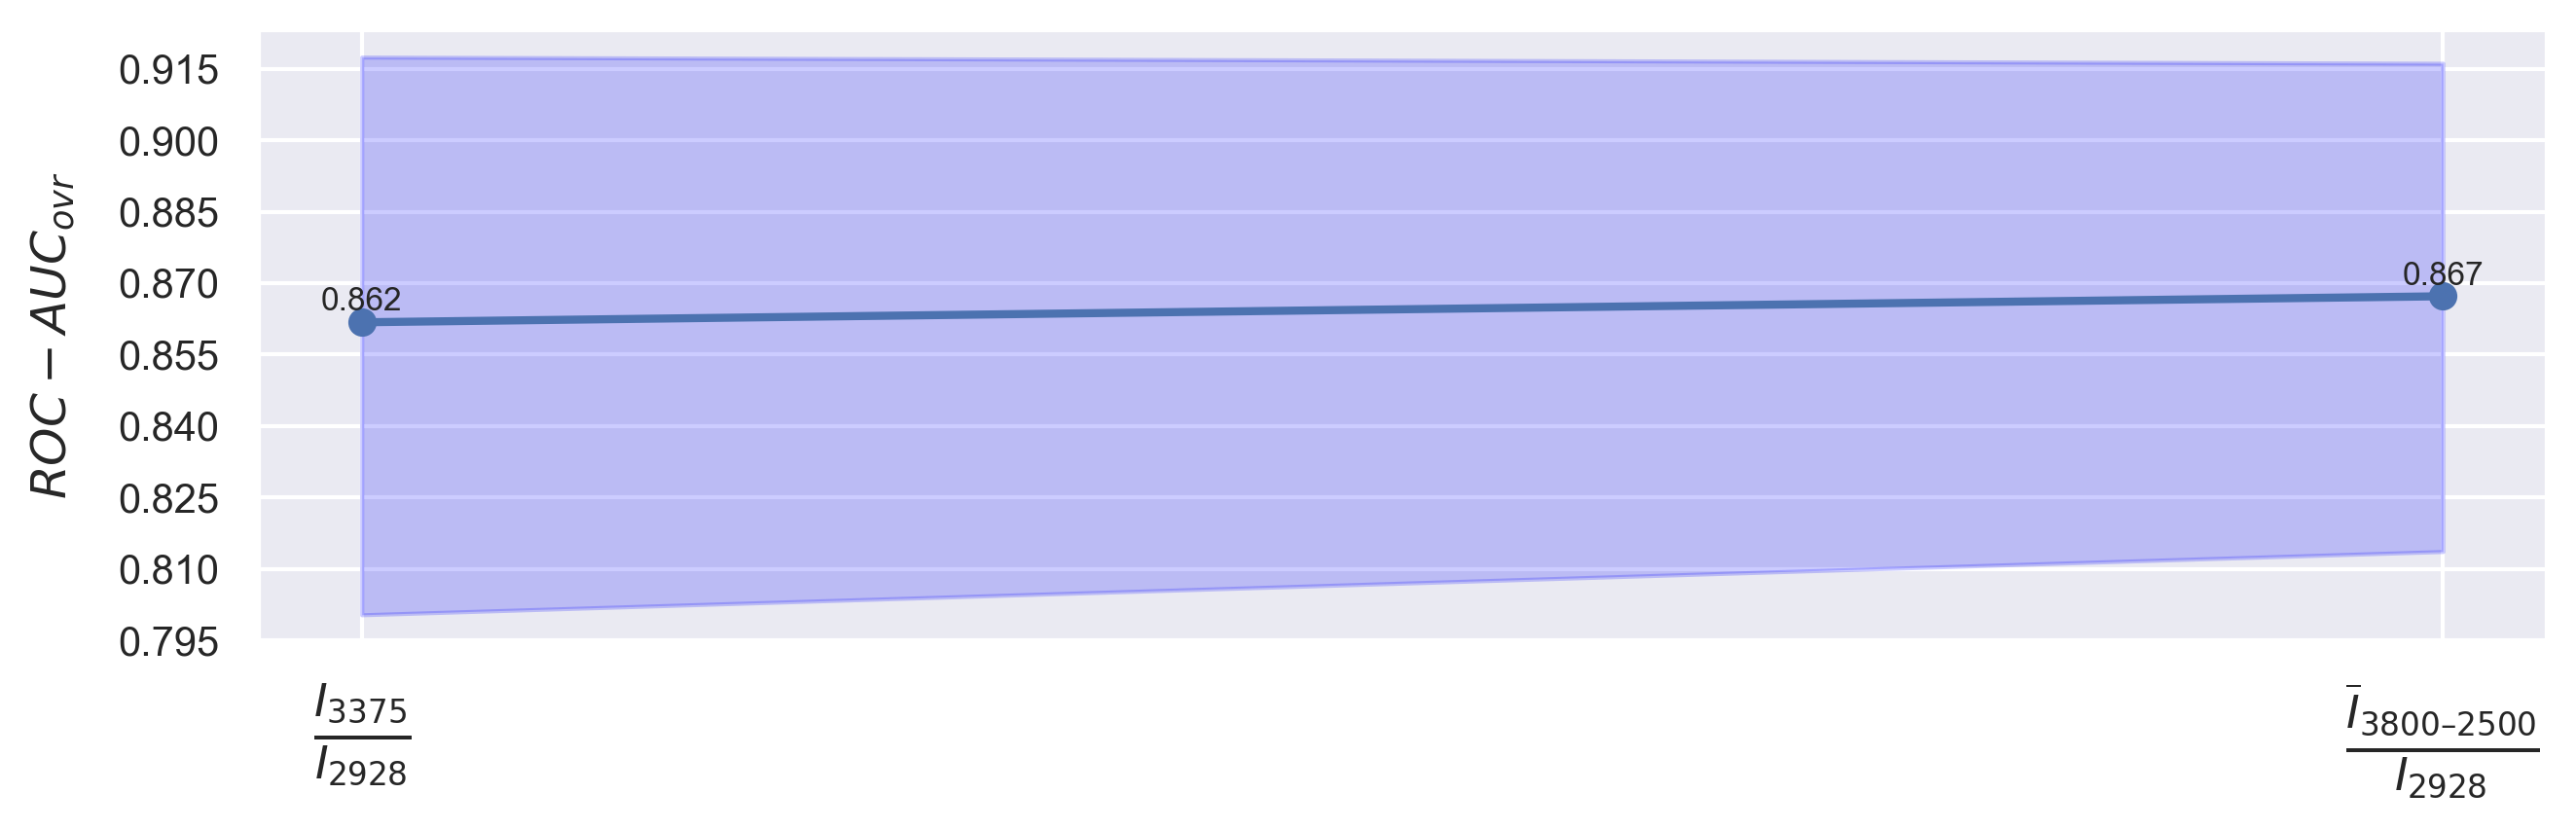

In [31]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line_bootstrap(
    selection_log=selection_log_3800_2500,
    ax=ax,
    show_ci=True
)

plt.tight_layout()
plt.savefig(f'{path_to_save}/fs_3800_2500_uplift_lineplot_bootstrap.png', dpi=600)
plt.show()

### `1900-800` cm$^{–1}$

#### Feature selection process

In [32]:
candidate_features_1900_800 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '1900_800' in feature_type:
            candidate_features_1900_800.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_1900_800)}')

Число фичей для многофакторного анализа: 20


In [33]:
%%time

selected_feats_1900_800, selection_log_1900_800 = forward_selection_bootstrap(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_1900_800,
    scoring='roc_auc_ovr',
    min_uplift=0.005,
    max_features=7,
    n_bootstrap=50,
    uplift_type='mean',  # 'mean', 'low', 'high'
    n_jobs=-1
)

Step 1:   0%|          | 0/20 [00:00<?, ?it/s]

Step 2:   0%|          | 0/19 [00:00<?, ?it/s]

Step 3:   0%|          | 0/18 [00:00<?, ?it/s]

Step 4:   0%|          | 0/17 [00:00<?, ?it/s]

Step 5:   0%|          | 0/16 [00:00<?, ?it/s]

Step 6:   0%|          | 0/15 [00:00<?, ?it/s]

Step 7:   0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 133 ms, sys: 30.4 ms, total: 164 ms
Wall time: 3.79 s


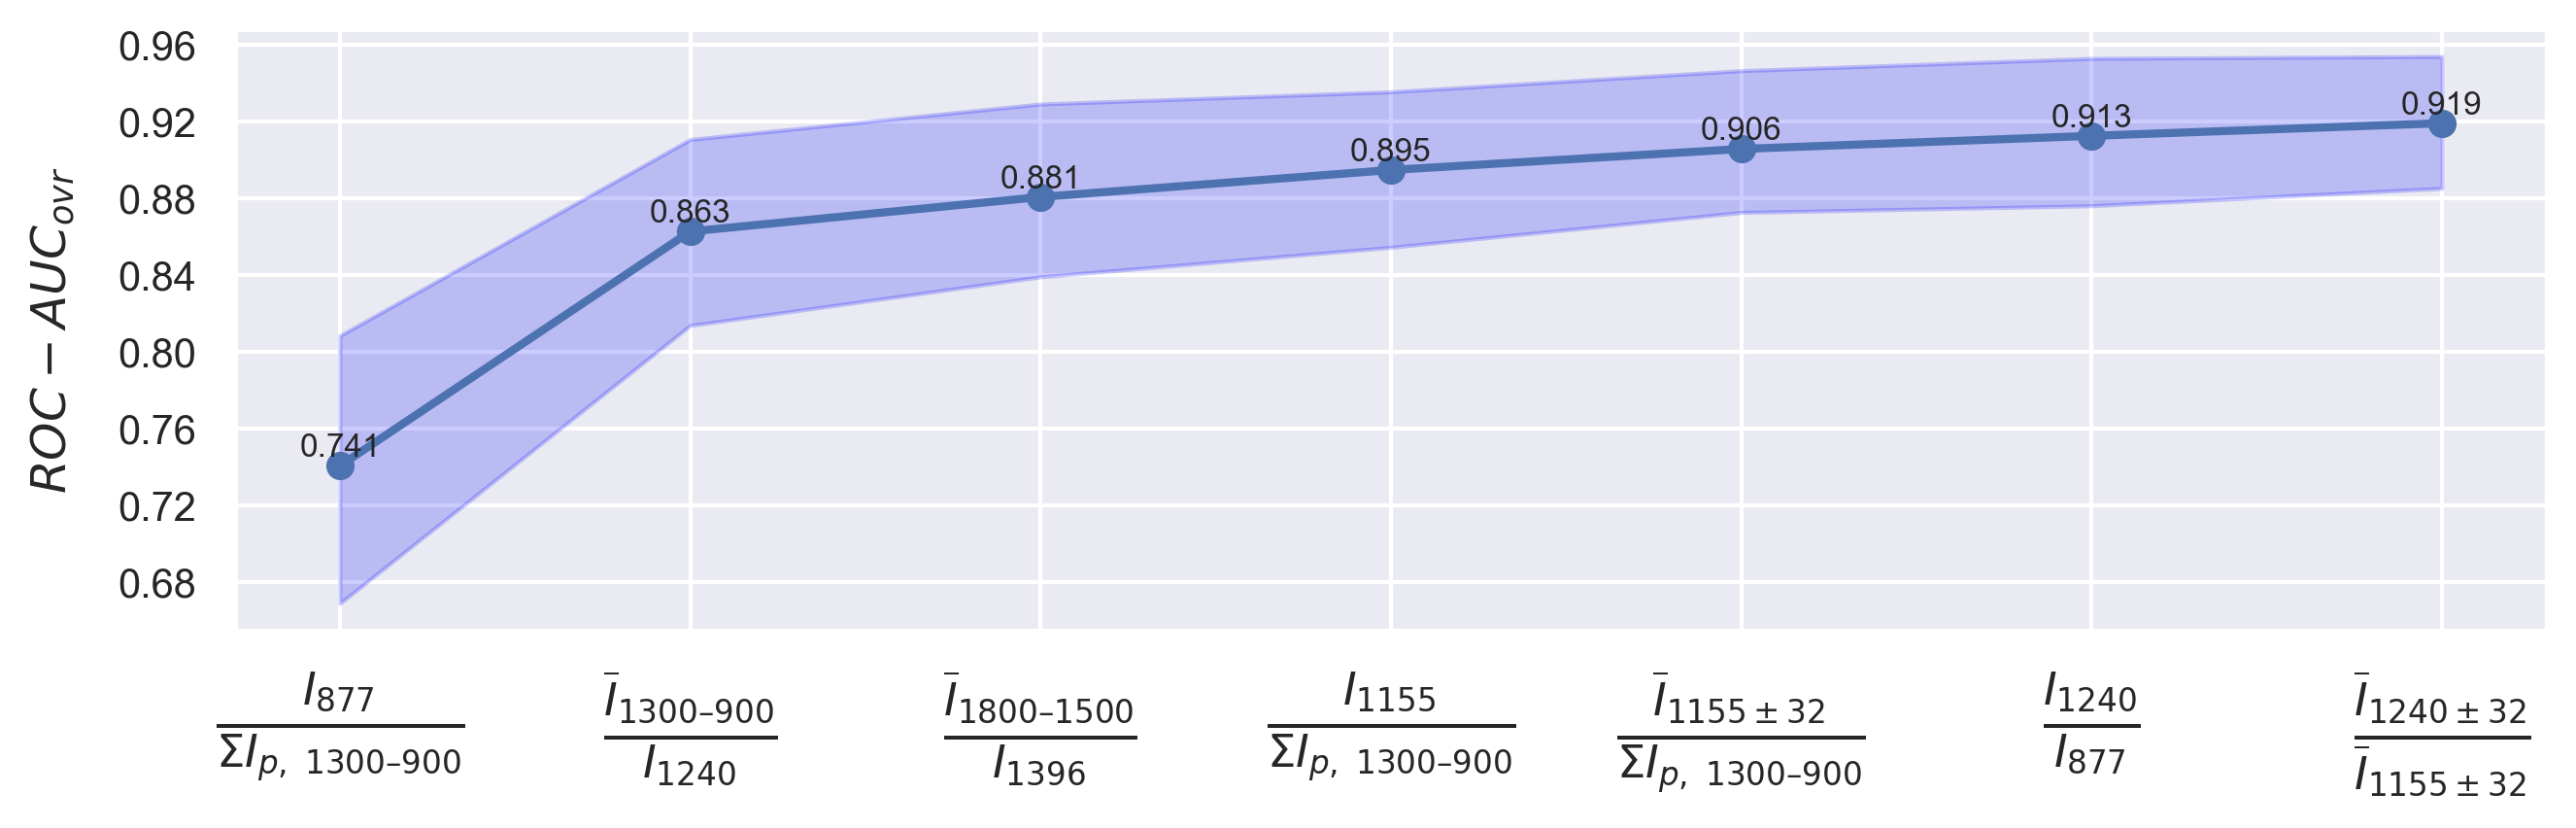

In [34]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line_bootstrap(
    selection_log=selection_log_1900_800,
    ax=ax,
    show_ci=True
)

plt.tight_layout()
plt.savefig(f'{path_to_save}/fs_1900_800_uplift_lineplot_bootstrap.png', dpi=600)
plt.show()

### `3800-2500` x `1900-800` cm$^{–1}$

In [35]:
candidate_features_3800_2500_1900_800 = of_features_to_save.copy()

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2500_1900_800)}')

Число фичей для многофакторного анализа: 65


In [36]:
%%time

selected_feats_3800_2500_1900_800, selection_log_3800_2500_1900_800 = forward_selection_bootstrap(
    features_df=features_df,
    target=target,
    candidate_features=candidate_features_3800_2500_1900_800,
    scoring='roc_auc_ovr',
    min_uplift=0.005,
    max_features=5,
    n_bootstrap=50,
    uplift_type='mean',  # 'mean', 'low', 'high'
    n_jobs=-1
)

Step 1:   0%|          | 0/65 [00:00<?, ?it/s]

Step 2:   0%|          | 0/64 [00:00<?, ?it/s]

Step 3:   0%|          | 0/63 [00:00<?, ?it/s]

Step 4:   0%|          | 0/62 [00:00<?, ?it/s]

Step 5:   0%|          | 0/61 [00:00<?, ?it/s]

CPU times: user 358 ms, sys: 100 ms, total: 459 ms
Wall time: 9.07 s


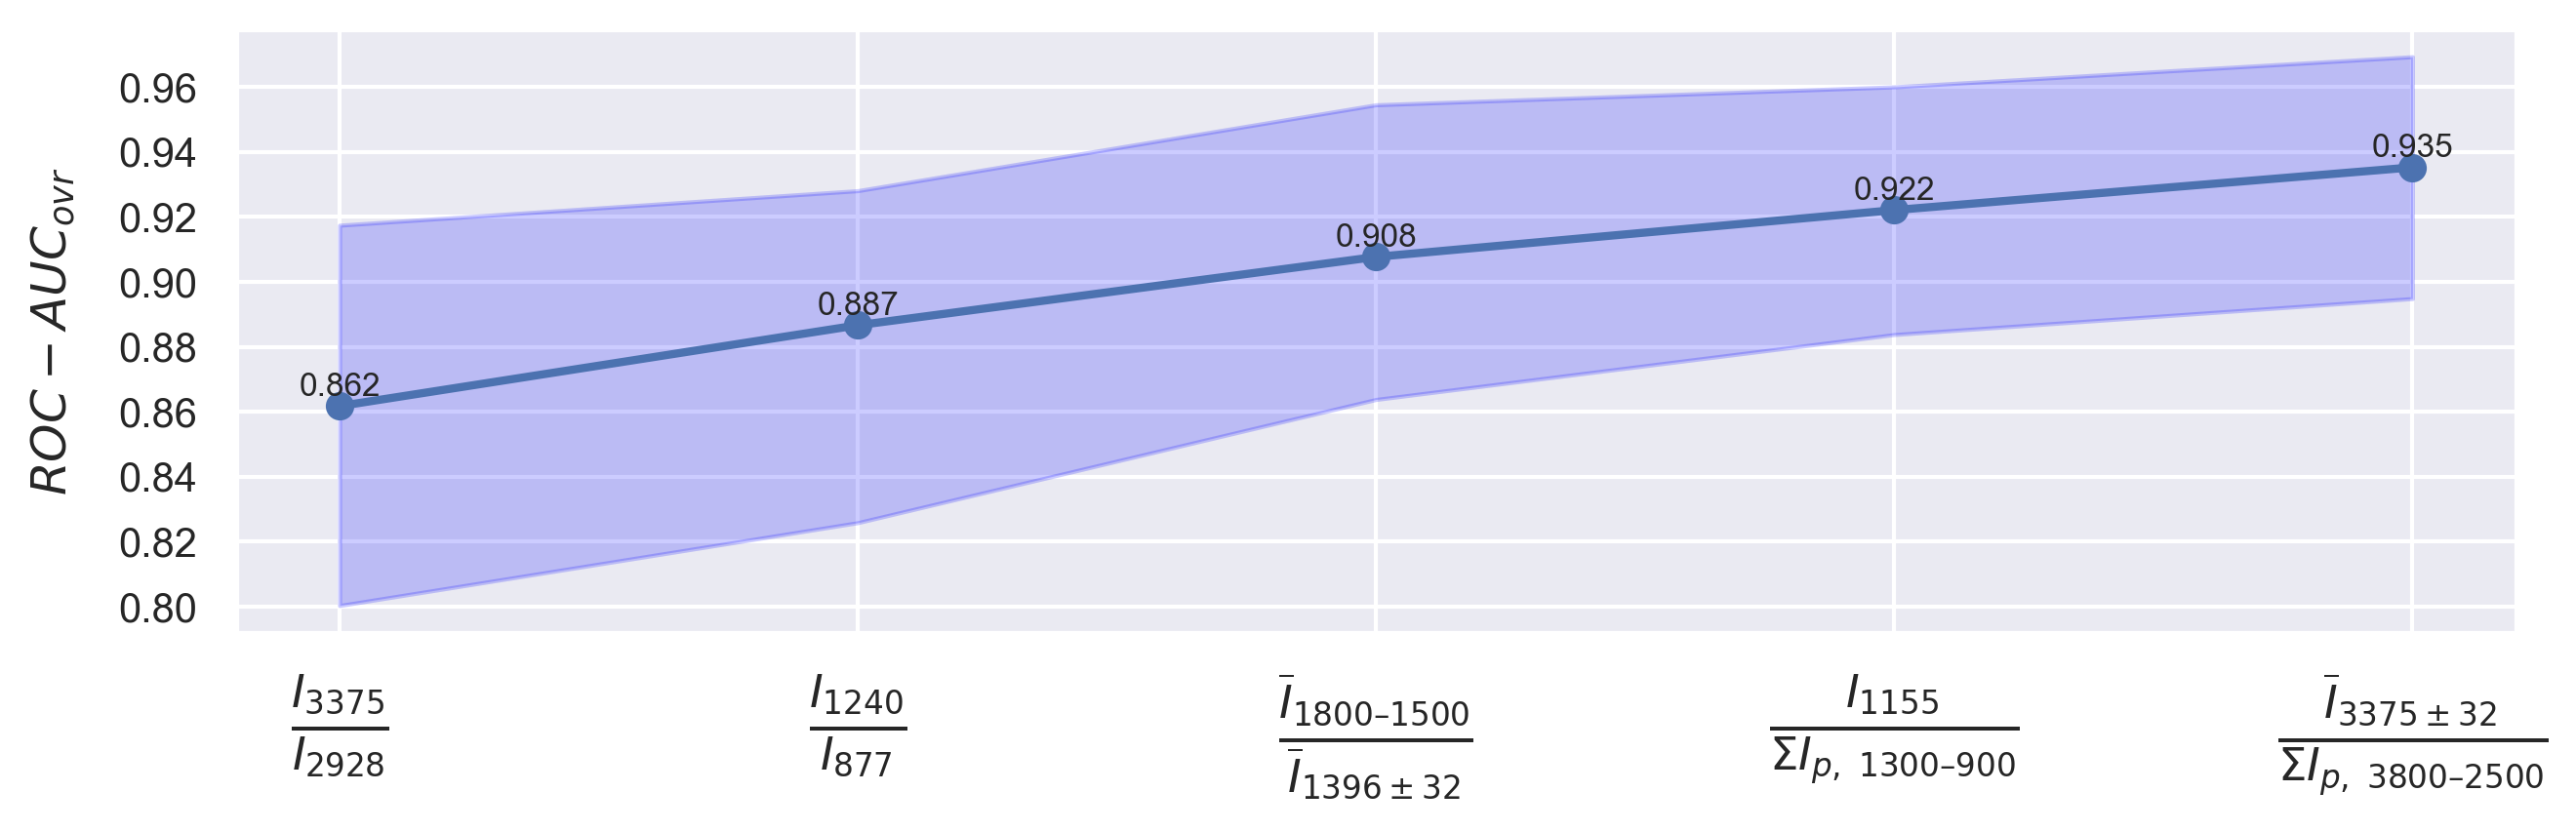

In [37]:
ig, ax = plt.subplots(figsize=(9, 3), dpi=300)

plot_cumulative_score_line_bootstrap(
    selection_log=selection_log_3800_2500_1900_800,
    ax=ax,
    show_ci=True
)

plt.tight_layout()
plt.savefig(f'{path_to_save}/fs_3800_2500_1900_800_uplift_lineplot_bootstrap.png', dpi=600)
plt.show()

## Models analysis

### Functions for processing

#### Modeling process (*scaling, `lr` fitting, cross-validation, metrics calculation*)

In [38]:
def logreg_full_bootstrap_cv_analysis(df, feature_list, target, cv_folds=5, random_state=42, C_values=None, n_bootstrap=50):
    X = df[feature_list].copy()
    y = target.copy()

    def optimize_C(X_train, y_train, C_values, scoring='roc_auc'):
        if C_values is None:
            C_values = np.logspace(-4, 4, 30)

        scores = []
        for C in C_values:
            clf = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000))
            clf.fit(X_train, y_train)
            y_proba = clf.predict_proba(X_train)
            score = roc_auc_score(y_train, y_proba, multi_class='ovr', average='macro')
            scores.append(score)

        c_metric_df = pd.DataFrame({'C': C_values, scoring: scores})
        best_C = c_metric_df.loc[c_metric_df[scoring].idxmax(), 'C']
        return best_C, c_metric_df

    # --- 1. Global model ---
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_list)

    best_C_full, c_metric_df = optimize_C(X_scaled, y, C_values)

    clf_full = OneVsRestClassifier(LogisticRegression(C=best_C_full, max_iter=1000))
    clf_full.fit(X_scaled, y)

    y_proba_full = clf_full.predict_proba(X_scaled)

    roc_auc_full = roc_auc_score(y, y_proba_full, multi_class='ovr', average='macro')
    pr_auc_full = average_precision_score(y, y_proba_full, average='macro')

    coef_df = pd.DataFrame(
        [est.coef_.flatten() for est in clf_full.estimators_],
        columns=feature_list,
        index=[f'Class {c}' for c in clf_full.classes_]
    )
    coef_df['Intercept'] = [est.intercept_[0] for est in clf_full.estimators_]

    scaler_df = pd.DataFrame({'Feature': feature_list, 'Mean': scaler.mean_, 'Std': scaler.scale_})

    # --- 2. Bootstrap ---
    rng = np.random.RandomState(random_state)
    roc_auc_boot, pr_auc_boot = [], []

    for _ in tqdm(range(n_bootstrap), desc='Bootstrap'):
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb, yb = X.iloc[idx], y.iloc[idx]
        Xb_scaled = pd.DataFrame(scaler.transform(Xb), columns=feature_list)

        C_boot, _ = optimize_C(Xb_scaled, yb, C_values)

        clf_boot = OneVsRestClassifier(LogisticRegression(C=C_boot, max_iter=1000))
        clf_boot.fit(Xb_scaled, yb)
        yb_proba = clf_boot.predict_proba(Xb_scaled)

        roc_auc_boot.append(roc_auc_score(yb, yb_proba, multi_class='ovr', average='macro'))
        pr_auc_boot.append(average_precision_score(yb, yb_proba, average='macro'))

    def ci_percentile(data, lower=5, upper=95):
        return np.percentile(data, lower), np.percentile(data, upper)

    # --- 3. Cross-validation ---
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    roc_auc_train_list, roc_auc_test_list = [], []
    pr_auc_train_list, pr_auc_test_list = [], []

    for train_idx, test_idx in tqdm(skf.split(X, y), total=cv_folds, desc='CV'):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        scaler_cv = StandardScaler()
        X_tr_scaled = pd.DataFrame(scaler_cv.fit_transform(X_tr), columns=feature_list)
        X_te_scaled = pd.DataFrame(scaler_cv.transform(X_te), columns=feature_list)

        C_cv, _ = optimize_C(X_tr_scaled, y_tr, C_values)

        clf_cv = OneVsRestClassifier(LogisticRegression(C=C_cv, max_iter=1000))
        clf_cv.fit(X_tr_scaled, y_tr)

        y_tr_proba = clf_cv.predict_proba(X_tr_scaled)
        y_te_proba = clf_cv.predict_proba(X_te_scaled)

        roc_auc_train_list.append(roc_auc_score(y_tr, y_tr_proba, multi_class='ovr', average='macro'))
        pr_auc_train_list.append(average_precision_score(y_tr, y_tr_proba, average='macro'))
        roc_auc_test_list.append(roc_auc_score(y_te, y_te_proba, multi_class='ovr', average='macro'))
        pr_auc_test_list.append(average_precision_score(y_te, y_te_proba, average='macro'))

    metrics_df = pd.DataFrame({
        '$ROC-AUC_{ovr}$': {
            'Train (CV mean)': np.mean(roc_auc_train_list),
            'Test (CV mean)': np.mean(roc_auc_test_list),
            'Bootstrap CI (5-95)': [round(ci, 4) for ci in ci_percentile(roc_auc_boot)],
            '$all$ $sample$': roc_auc_full
        },
        '$PR-AUC_{macro}$': {
            'Train (CV mean)': np.mean(pr_auc_train_list),
            'Test (CV mean)': np.mean(pr_auc_test_list),
            'Bootstrap CI (5-95)': [round(ci, 4) for ci in ci_percentile(pr_auc_boot)],
            '$all$ $sample$': pr_auc_full
        }
    })

    return clf_full, X_scaled, scaler_df, coef_df, metrics_df, best_C_full, c_metric_df

#### `C` optimaztion visualization

In [39]:
def plot_c_metric_curve(c_metric_df, metric_name='roc_auc', best_C=None, ax=None):
    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300) if not external_ax else (None, ax)

    sns.lineplot(
        data=c_metric_df,
        x='C',
        y=metric_name,
        color='teal',
        linewidth=3.5,
        ax=ax
    )

    ax.set_xscale('log')

    if best_C is not None:
        best_y = c_metric_df.loc[c_metric_df['C'] == best_C, metric_name].values
        if len(best_y):
            ax.axvline(x=best_C, color='darkred', linestyle='--', linewidth=1.8)
            ax.scatter(best_C, best_y[0], color='darkred', s=50, zorder=5)

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if not external_ax:
        plt.tight_layout()
        plt.show()

#### *ROC*-curves visualization

In [40]:
def plot_roc_curve_per_class(model, X_scaled, y_true, class_index, ax):
    y_score = model.predict_proba(X_scaled)
    classes = model.classes_
    y_bin = label_binarize(y_true, classes=classes)

    fpr, tpr, _ = roc_curve(y_bin[:, class_index], y_score[:, class_index])
    roc_auc = auc(fpr, tpr)

    class_label = class_fraction_group_dict[class_index]
    class_color = type_color_dict[class_label]

    ax.plot(
        fpr,
        tpr,
        color=class_color,
        linewidth=PLOT_STYLE['LINE_WIDTH'],
        label=fr'$ROC\text{{-}}AUC_{{ovr}} = {roc_auc:.2f}$'
    )

    ax.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        color='gray',
        linewidth=PLOT_STYLE['LINE_WIDTH'] - 1.5,
        label='$ROC-AUC = 0.50$\n$(random$ $classifier)$'
    )

    ax.set_title(class_label, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))
    
    ax.legend(loc='lower right', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'])

#### *SHAP*-values visualization (*beeswarm*)

In [41]:
def plot_shap_summary_logreg(model, X_scaled, features_lst, class_index=0, max_display=20, show_colorbar=True, ax=None):
    base_model = model.estimators_[class_index] if hasattr(model, 'estimators_') else model

    explainer = shap.LinearExplainer(base_model, X_scaled, feature_perturbation='interventional')
    shap_values = explainer(X_scaled)
    shap_values.feature_names = list(features_lst)

    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)

    shap.plots.beeswarm(
        shap_values,
        max_display=max_display,
        show=False,
        color_bar=show_colorbar,
        ax=ax,
        s=PLOT_STYLE['DOT_SIZE'],
        plot_size=None
    )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if show_colorbar:
        fig = plt.gcf()
        for other_ax in fig.axes:
            if other_ax is not ax and len(other_ax.get_xticks()) == 0 and len(other_ax.get_yticks()) > 0:
                other_ax.set_ylabel(PLOT_STYLE['LEGEND_TITLE'], fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'])
                other_ax.tick_params(labelsize=PLOT_STYLE['LEGEND_FONT_SIZE'])

                if 'COLORBAR_TICKS' in PLOT_STYLE:
                    other_ax.set_yticklabels(PLOT_STYLE['COLORBAR_TICKS'])

    if not external_ax:
        plt.tight_layout()
        plt.show()

#### Feature importance (feature weight) barplot

In [42]:
def plot_feature_importance_logreg(model, features_lst, max_display=20, ax=None):
    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)

    if hasattr(model, 'estimators_'):
        coefs = np.vstack([est.coef_ for est in model.estimators_])
    else:
        coefs = model.coef_

    importance = np.abs(coefs).mean(axis=0)
    rel_importance = 100 * importance / importance.sum()

    rel_series = pd.Series(rel_importance, index=features_lst).sort_values(ascending=False).head(max_display)

    palette = sns.color_palette(PLOT_STYLE['PALETTE'], n_colors=len(rel_series))
    colors = list(palette)[::-1]

    rel_series[::-1].plot(kind='barh', ax=ax, color=colors)

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if not external_ax:
        plt.tight_layout()
        plt.show()

### `3800-2500` cm$^{-1}$

In [43]:
range_ = '3800_2500'

*Short-list of features additional correction*

In [44]:
features_to_exclude_by_shap = [
    r'$\frac{\overline{I}_{3800\text{–}2500}}{I_{3383}}$',
    r'$\frac{\overline{I}_{3737 \pm 32}}{\overline{I}_{3383 \pm 32}}$'
]

selected_feats_3800_2500 = [feature for feature in selected_feats_3800_2500 if feature not in features_to_exclude_by_shap]

#### Model fitting

In [45]:
model, X_scaled, scaler_df, coef_df, metrics_df, best_C_full, c_metric_df = logreg_full_bootstrap_cv_analysis(
    df=features_df,
    feature_list=selected_feats_3800_2500,
    target=target,
    cv_folds=5,
    random_state=42,
    C_values=None,
    n_bootstrap=50
)

print(X_scaled.shape)
X_scaled.head(3)

Bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

CV:   0%|          | 0/5 [00:00<?, ?it/s]

(75, 2)


,$\frac{I_{3375}}{I_{2928}}$,$\frac{\overline{I}_{3800\text{–}2500}}{I_{2928}}$
0,0.939194,1.030986
1,1.467786,1.341099
2,0.506067,0.425001


*Parameters for scaling*

In [46]:
display(scaler_df.T)

,0,1
Feature,$\frac{I_{3375}}{I_{2928}}$,$\frac{\overline{I}_{3800\text{–}2500}}{I_{2928}}$
Mean,1.174717,0.723433
Std,0.87388,0.336272


*Model parameters (weights & intercept)*

In [47]:
display(coef_df)

,$\frac{I_{3375}}{I_{2928}}$,$\frac{\overline{I}_{3800\text{–}2500}}{I_{2928}}$,Intercept
Class 0,-2.742986,-0.907550,-2.664257
Class 1,-0.150278,-0.332614,-0.490714
Class 2,-3.463186,7.309472,-2.626495


*Model metrics*

In [48]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Train (CV mean),0.879862,0.786805
Test (CV mean),0.870756,0.799822
Bootstrap CI (5-95),"[0.8376, 0.9415]","[0.7433, 0.9045]"
$all$ $sample$,0.87931,0.782716


*Optimal inverse of regulation strength value*

#### Visualization of `C` optimization

In [49]:
print(f'Optimal value of regularization coefficient (C): {round(best_C_full, 4)}')

Optimal value of regularization coefficient (C): 62.1017


In [50]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3.3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Обратный коэффициент регуляризации ($C$)',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 11
}

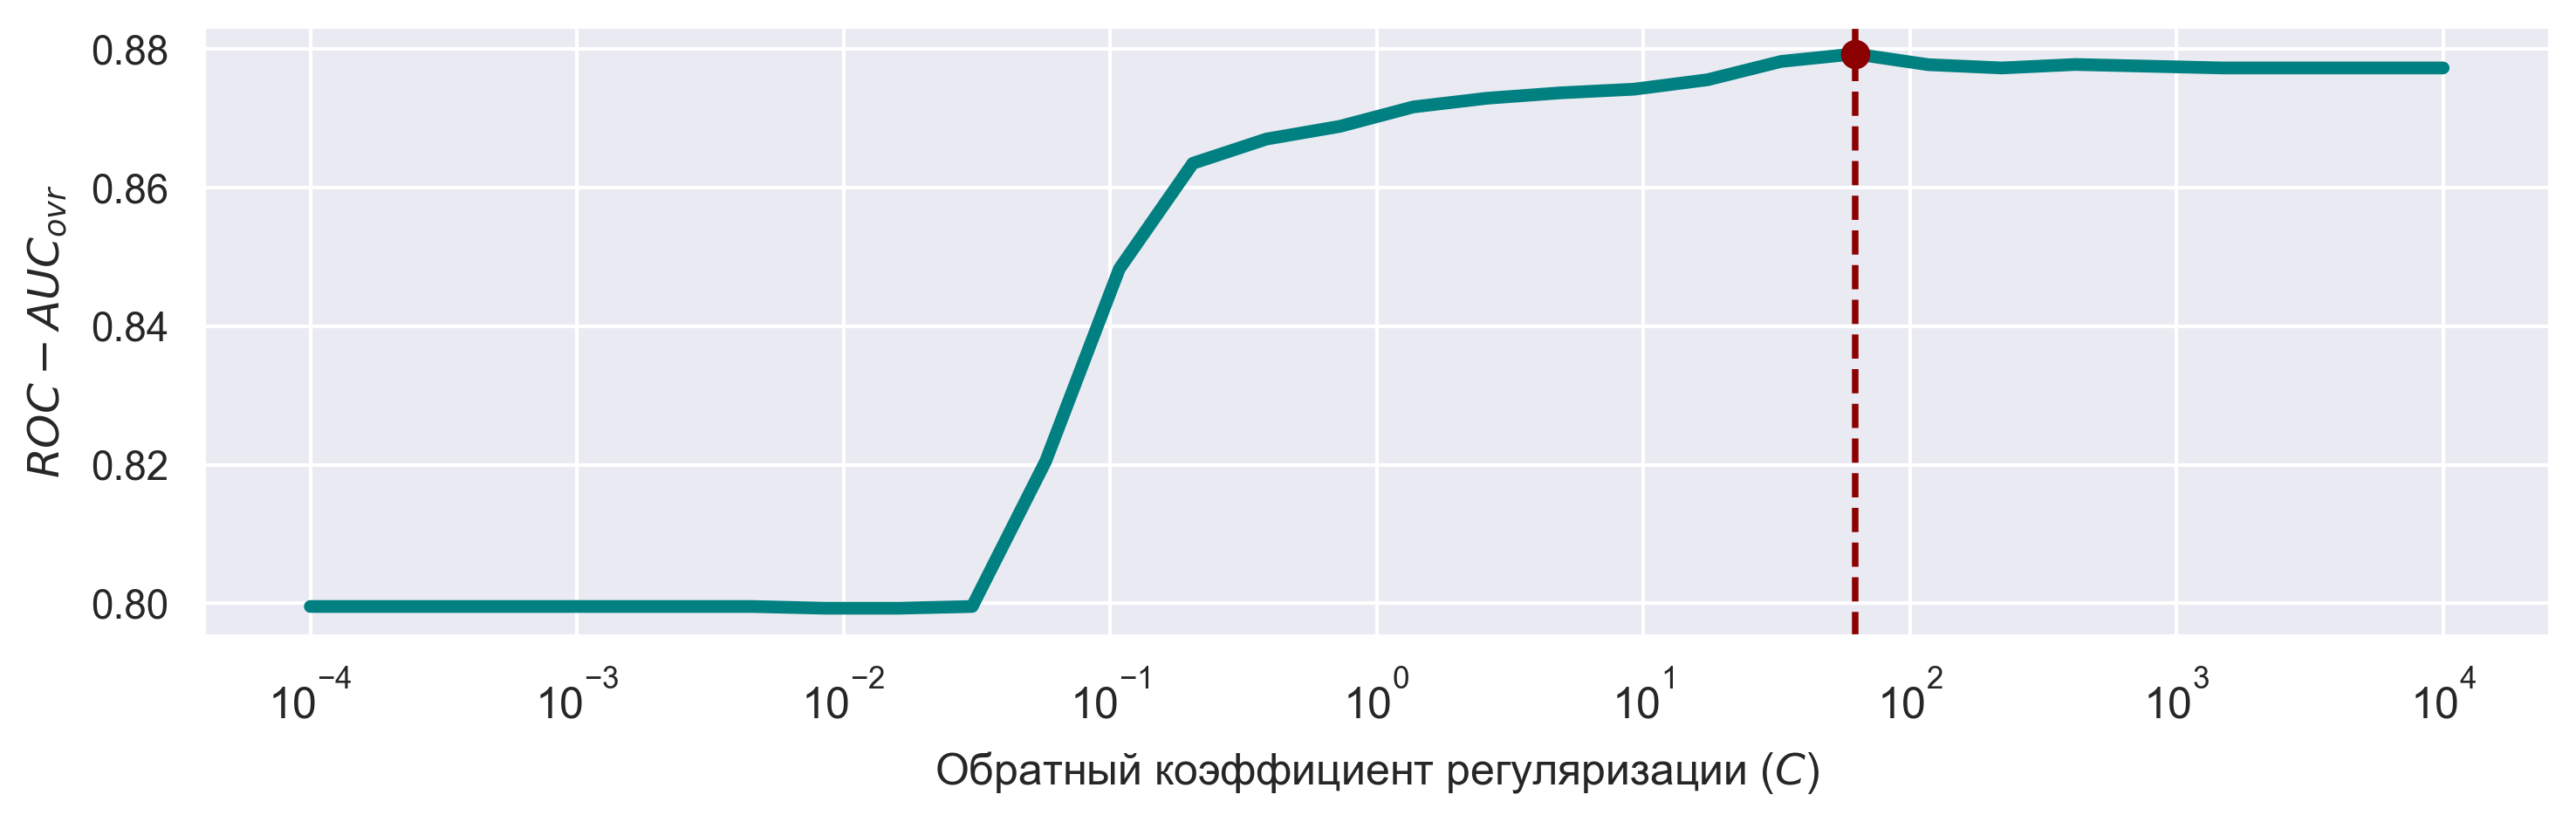

In [51]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_c_metric_curve(
    c_metric_df=c_metric_df,
    metric_name='roc_auc',
    best_C=best_C_full,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/c_optimization_curve_{range_}.png', dpi=600)

plt.show()

#### *ROC*-curves visualization

In [52]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

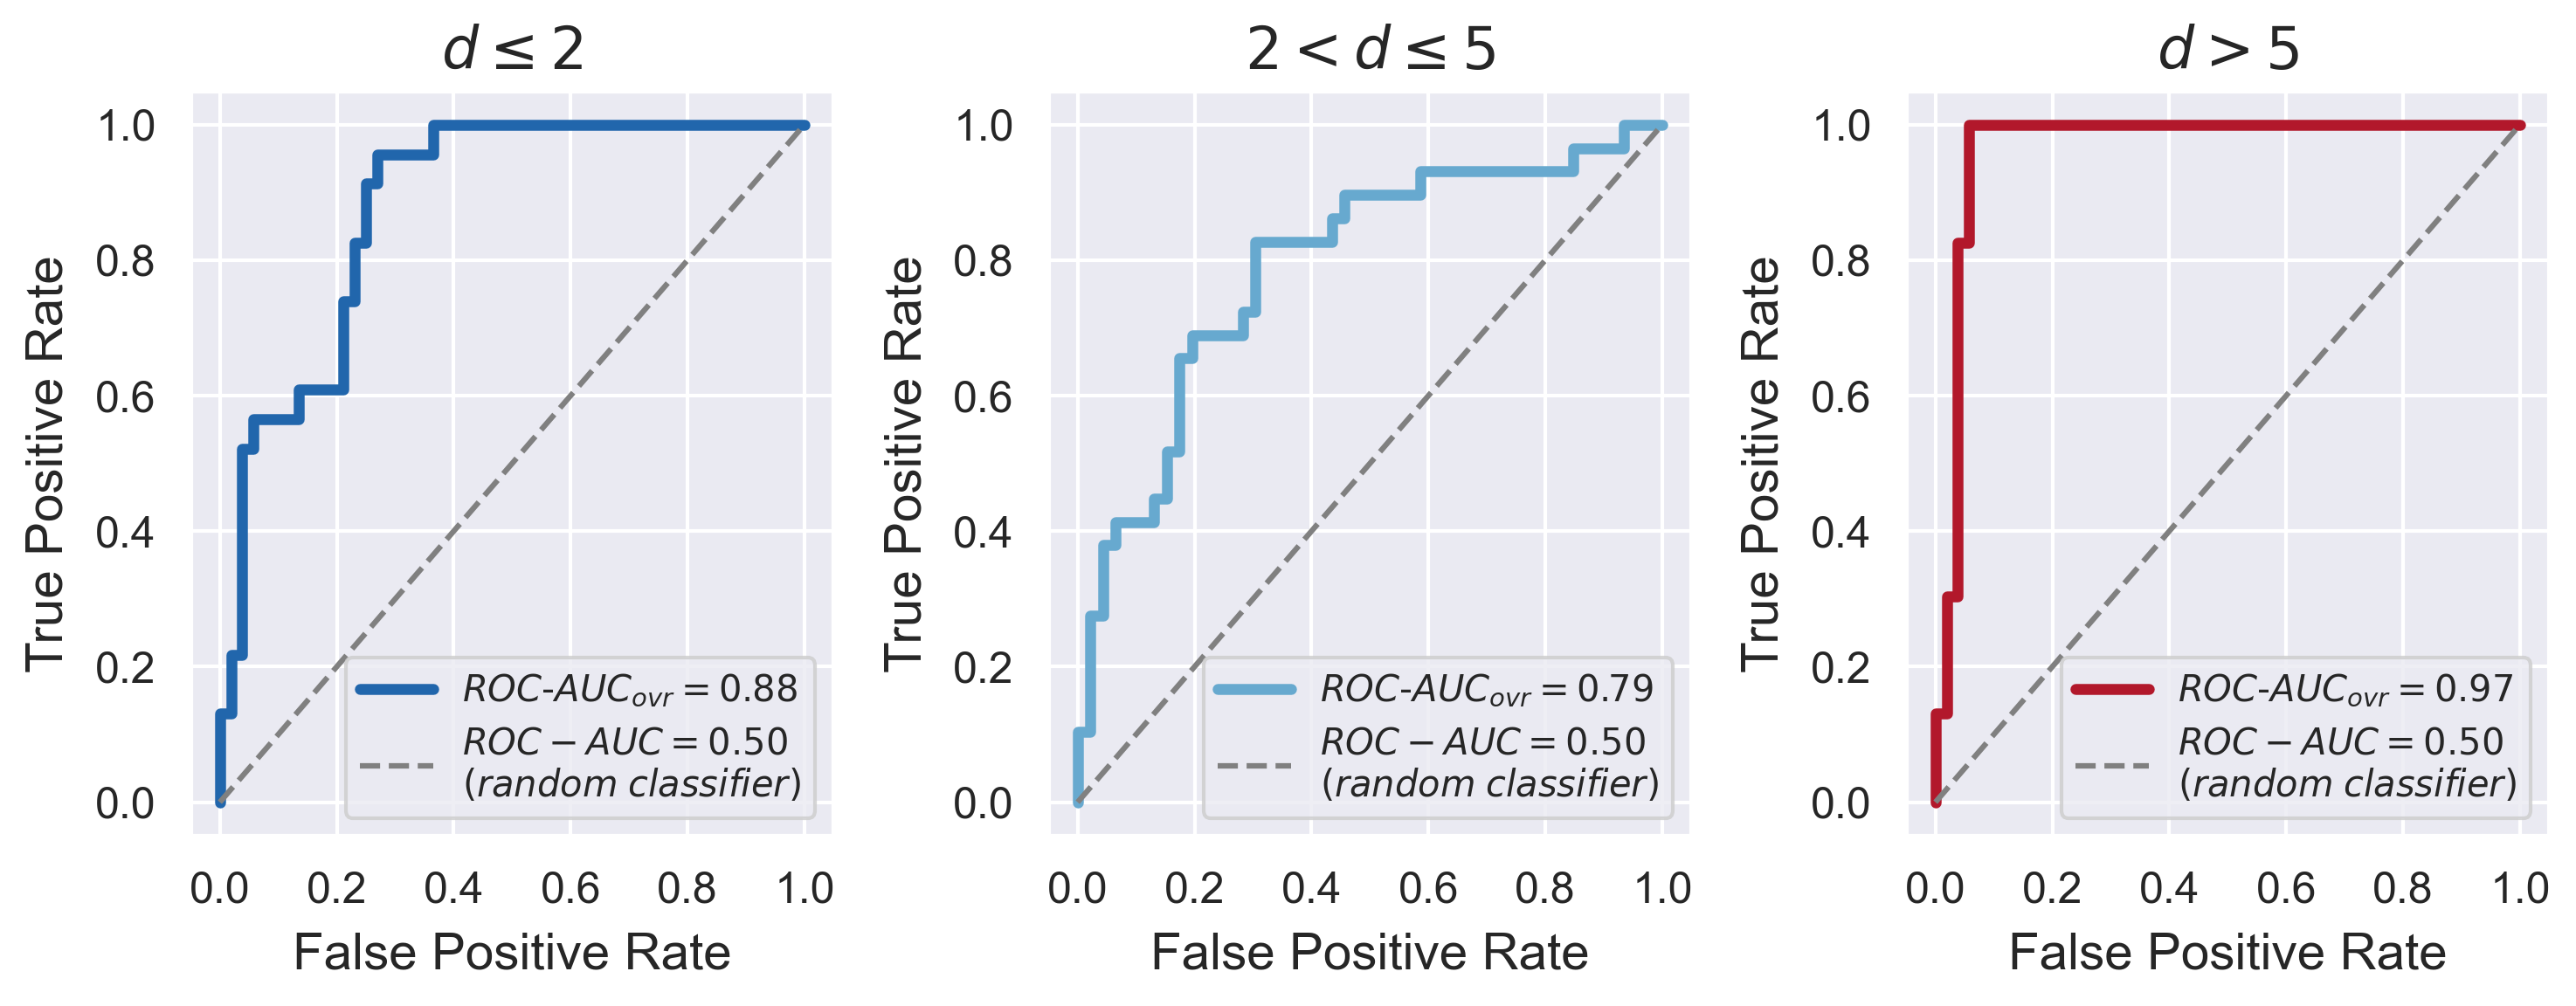

In [53]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X_scaled=X_scaled,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range_}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [54]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

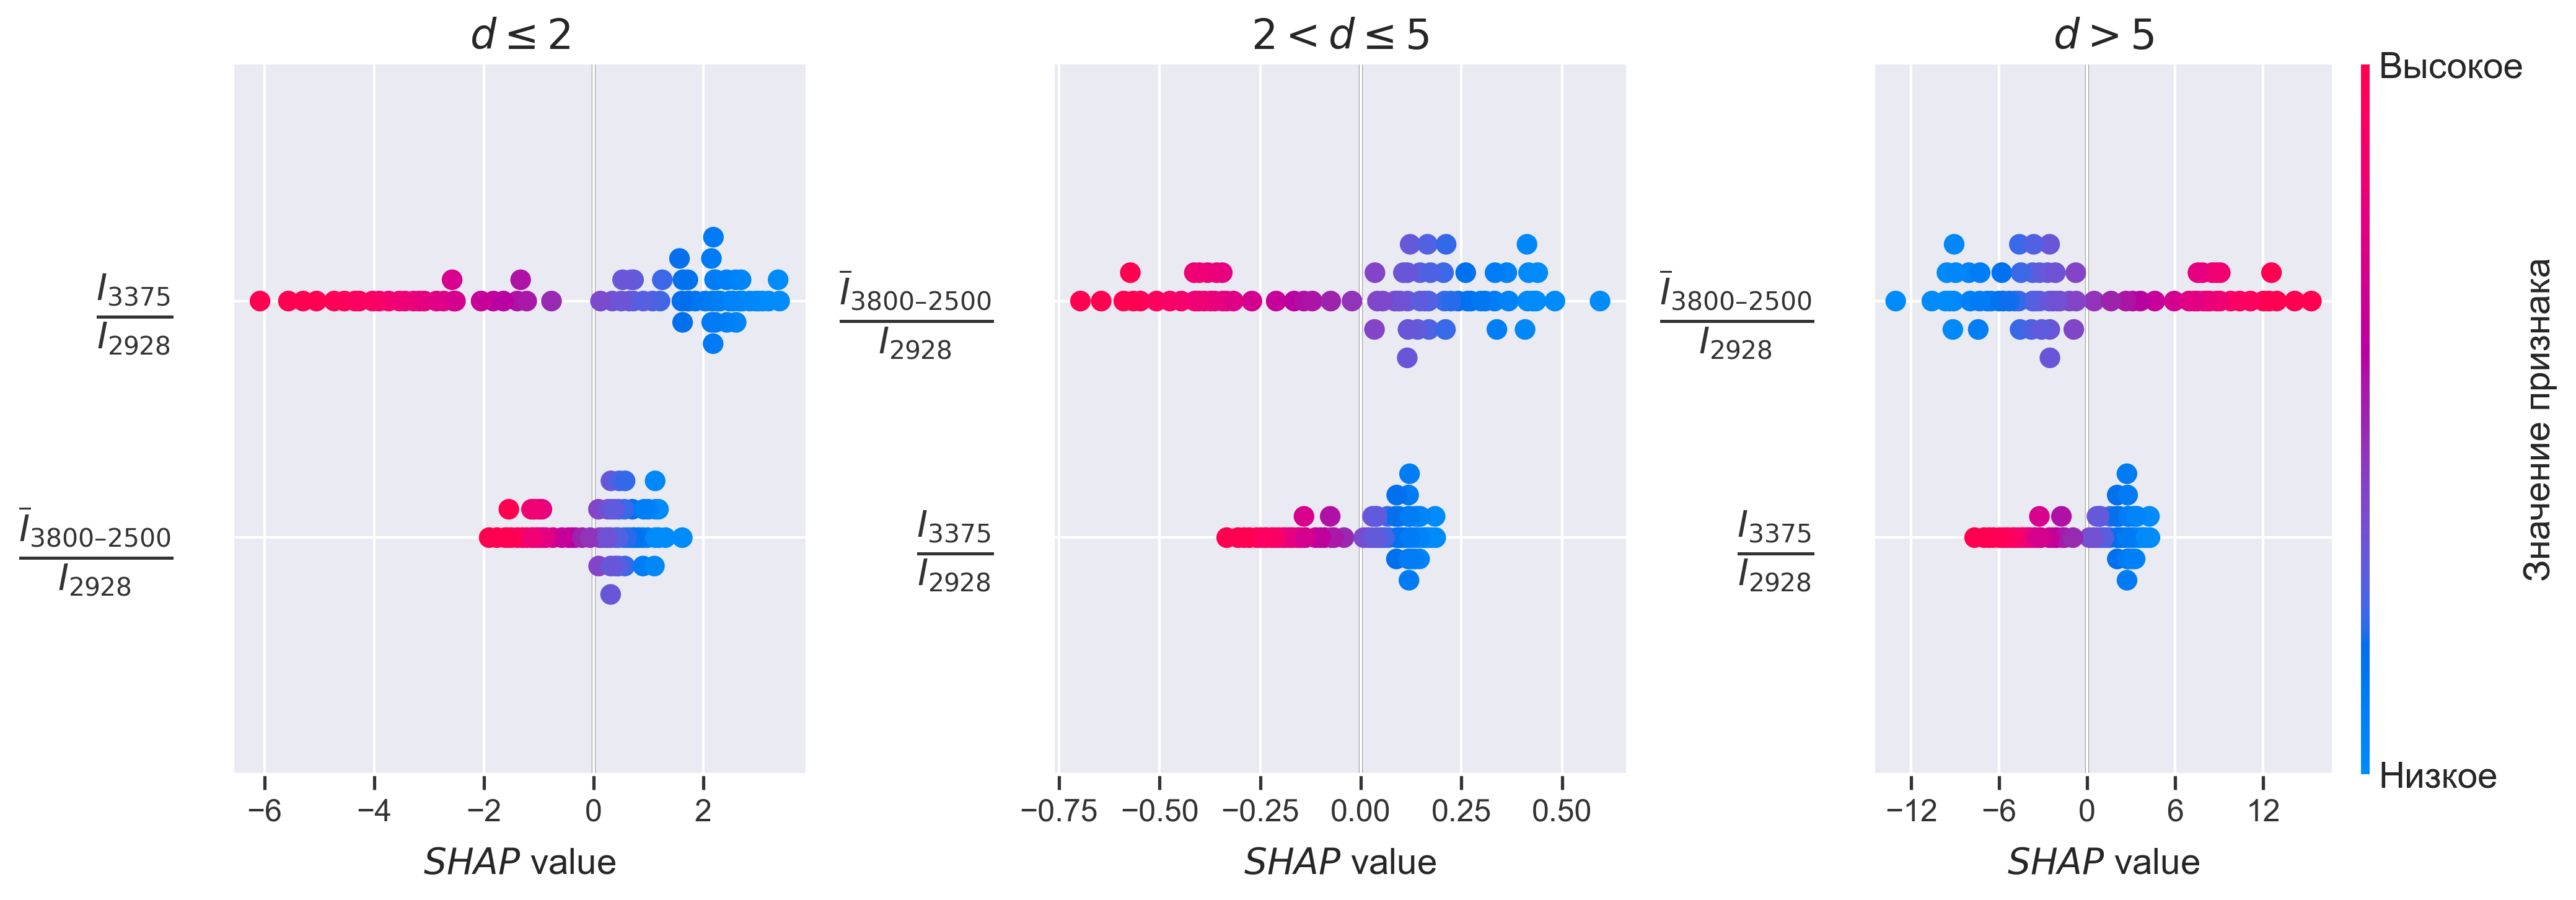

In [55]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):    
    show_colorbar = True if i == 2 else False

    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title
    
    plot_shap_summary_logreg(
        model=model,
        X_scaled=X_scaled,
        features_lst=X_scaled.columns.tolist(),
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/shap_3_subplots_{range_}.png', dpi=600)

plt.show()

#### *Feature importance* diagram

In [56]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Значимость признака (доля веса), %',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_NBINS': 20,
    'PALETTE': 'crest'
}

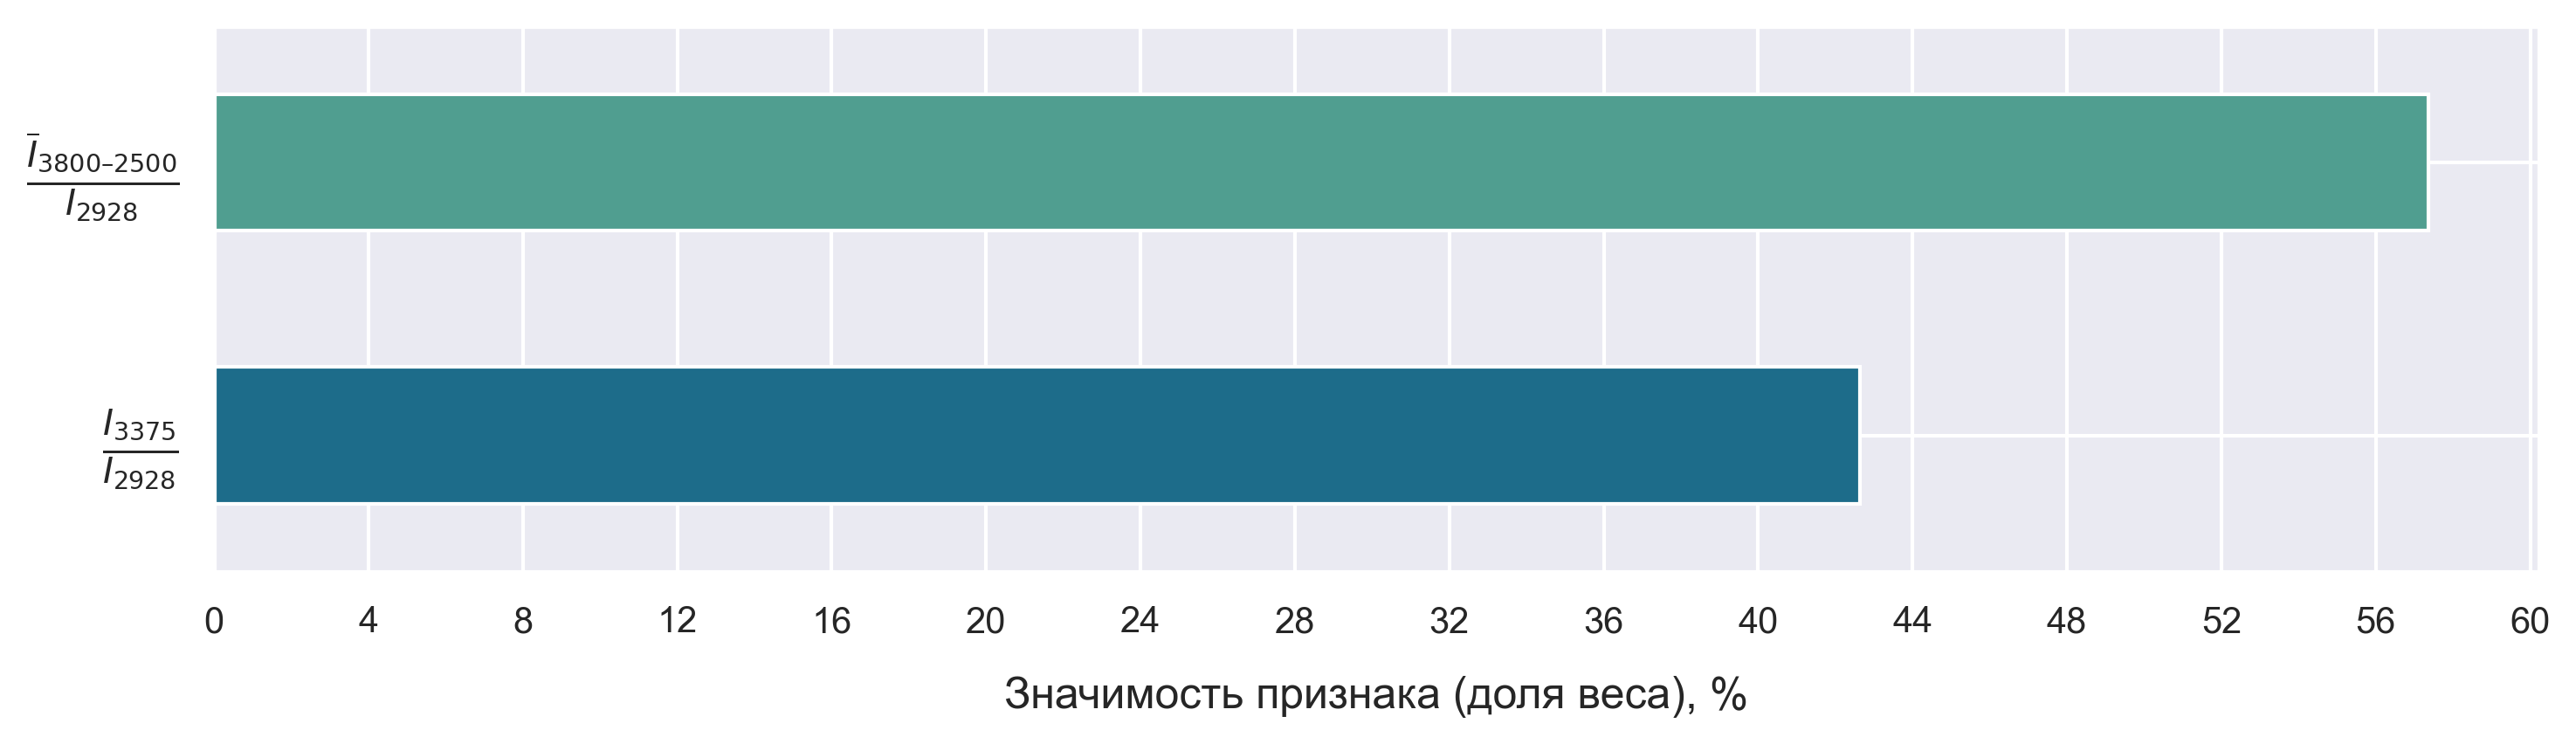

In [57]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_feature_importance_logreg(
    model=model,
    features_lst=X_scaled.columns.tolist(),
    max_display=15,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fi_barplot_{range_}.png', dpi=600)

plt.show()

### `1900-800` cm$^{-1}$

In [58]:
range_ = '1900_800'

#### Model fitting

In [59]:
model, X_scaled, scaler_df, coef_df, metrics_df, best_C_full, c_metric_df = logreg_full_bootstrap_cv_analysis(
    df=features_df,
    feature_list=selected_feats_1900_800,
    target=target,
    cv_folds=5,
    random_state=42,
    C_values=None,
    n_bootstrap=50
)

print(X_scaled.shape)
X_scaled.head(3)

Bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

CV:   0%|          | 0/5 [00:00<?, ?it/s]

(75, 7)


,"$\frac{I_{877}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{\overline{I}_{1300\text{–}900}}{I_{1240}}$,$\frac{\overline{I}_{1800\text{–}1500}}{I_{1396}}$,"$\frac{I_{1155}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{1155 \pm 32}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{I_{1240}}{I_{877}}$,$\frac{\overline{I}_{1240 \pm 32}}{\overline{I}_{1155 \pm 32}}$
0,-1.018759,-0.098882,-0.088756,-0.619484,-0.682572,0.356705,-0.036824
1,-0.677430,-0.235697,-0.041905,-0.324956,-0.223969,-0.212010,-0.218175
2,-0.673317,0.396216,0.148445,-0.029465,0.216623,-0.353422,-0.816298


*Parameters for scaling*

In [60]:
display(scaler_df.T)

,0,1,2,3,4,5,6
Feature,"$\frac{I_{877}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{\overline{I}_{1300\text{–}900}}{I_{1240}}$,$\frac{\overline{I}_{1800\text{–}1500}}{I_{1396}}$,"$\frac{I_{1155}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{1155 \pm 32}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{I_{1240}}{I_{877}}$,$\frac{\overline{I}_{1240 \pm 32}}{\overline{I}_{1155 \pm 32}}$
Mean,0.122065,1.032327,0.737352,0.359016,0.339297,6.323723,0.940783
Std,0.090019,0.482952,0.342365,0.104572,0.059876,8.293259,0.423035


*Model parameters (weights & intercept)*

In [61]:
display(coef_df)

,"$\frac{I_{877}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{\overline{I}_{1300\text{–}900}}{I_{1240}}$,$\frac{\overline{I}_{1800\text{–}1500}}{I_{1396}}$,"$\frac{I_{1155}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{1155 \pm 32}}{\Sigma I_{p,\ 1300\text{–}900}}$",$\frac{I_{1240}}{I_{877}}$,$\frac{\overline{I}_{1240 \pm 32}}{\overline{I}_{1155 \pm 32}}$,Intercept
Class 0,0.920442,1.934419,-0.048024,-3.222464,3.182115,0.222531,0.737089,-1.152734
Class 1,0.258064,-0.051191,1.201766,3.493917,-3.491826,-0.673565,-0.086982,-0.560391
Class 2,-5.372291,-44.498964,-38.659763,-19.801174,-5.270689,20.102528,-26.184935,-32.778569


*Model metrics*

In [62]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Train (CV mean),0.92631,0.867639
Test (CV mean),0.829928,0.760815
Bootstrap CI (5-95),"[0.8987, 0.9901]","[0.8303, 0.9775]"
$all$ $sample$,0.909334,0.841886


*Optimal inverse of regulation strength value*

#### Visualization of `C` optimization

In [63]:
print(f'Optimal value of regularization coefficient (C): {round(best_C_full, 4)}')

Optimal value of regularization coefficient (C): 10000.0


In [64]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3.3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Обратный коэффициент регуляризации ($C$)',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 11
}

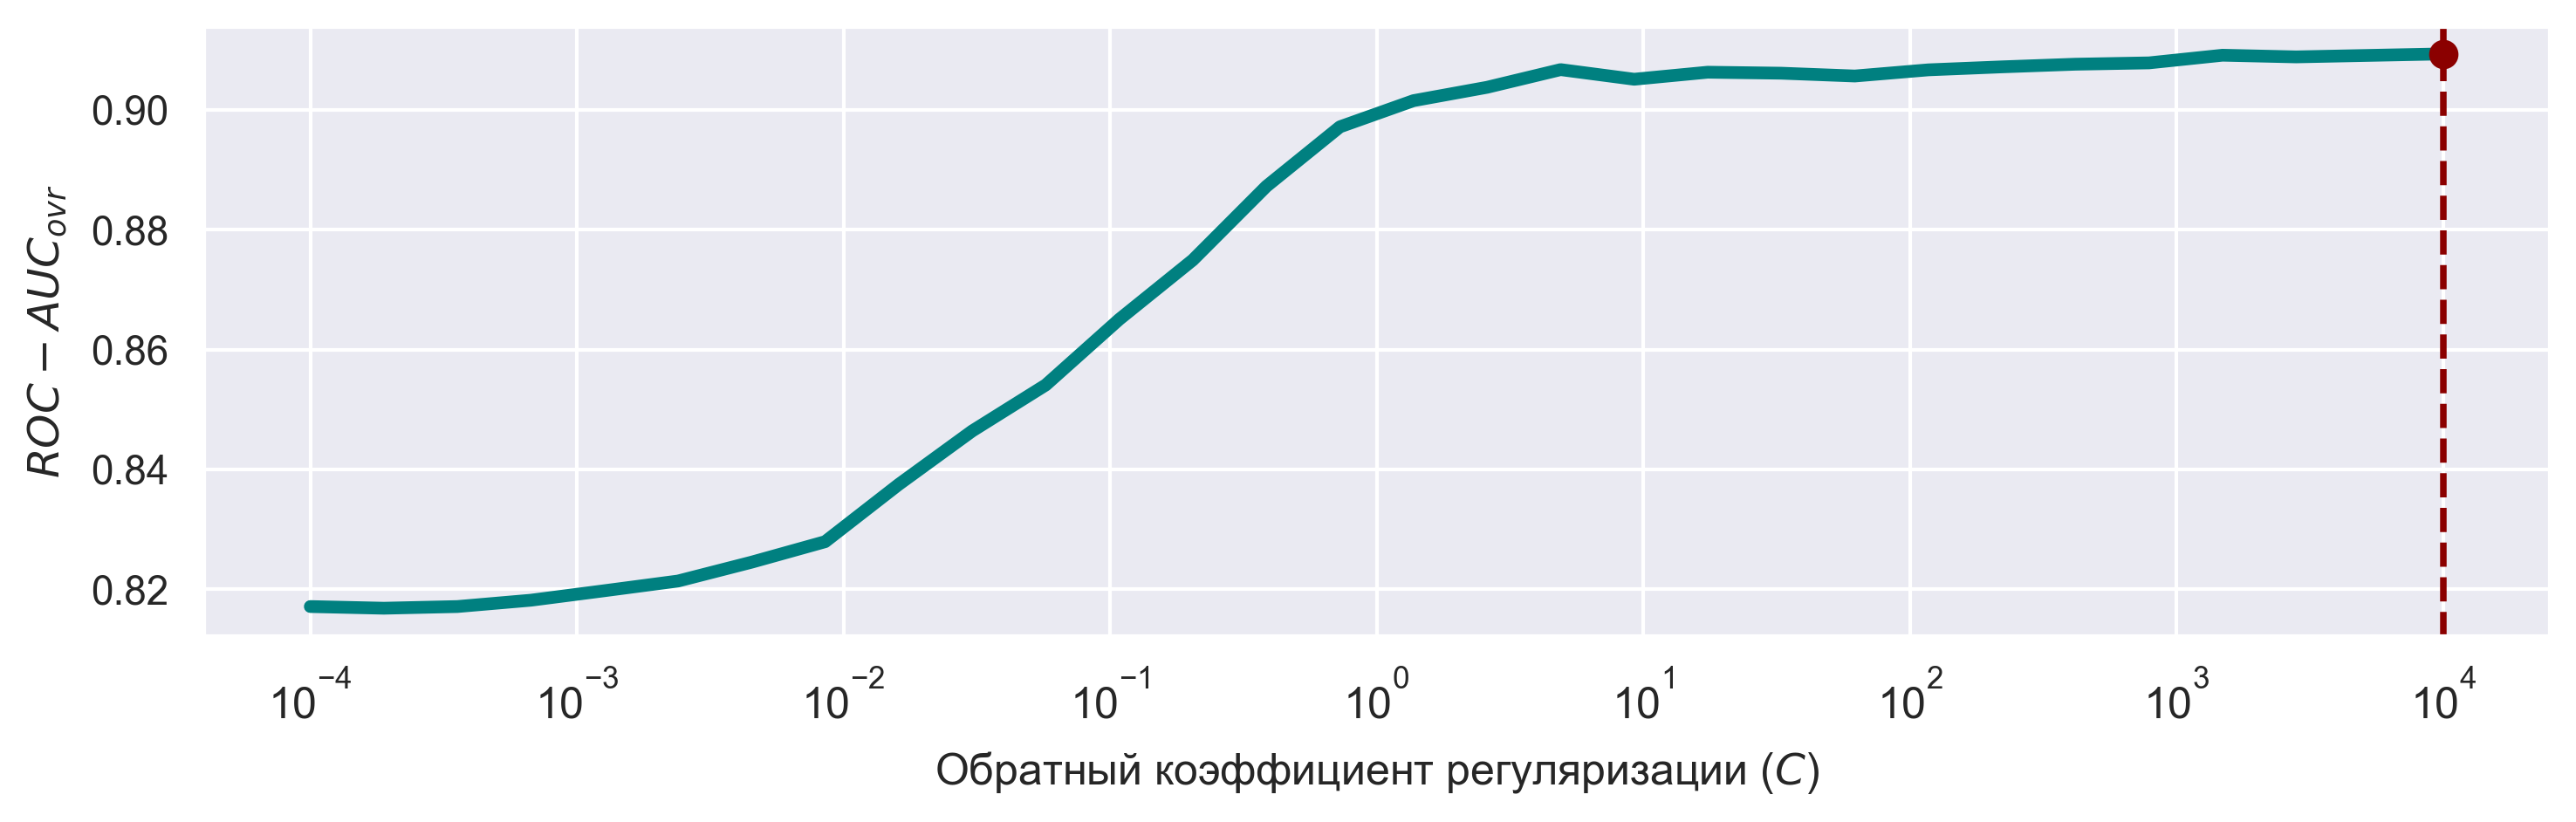

In [65]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_c_metric_curve(
    c_metric_df=c_metric_df,
    metric_name='roc_auc',
    best_C=best_C_full,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/c_optimization_curve_{range_}.png', dpi=600)

plt.show()

#### *ROC*-curves visualization

In [66]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

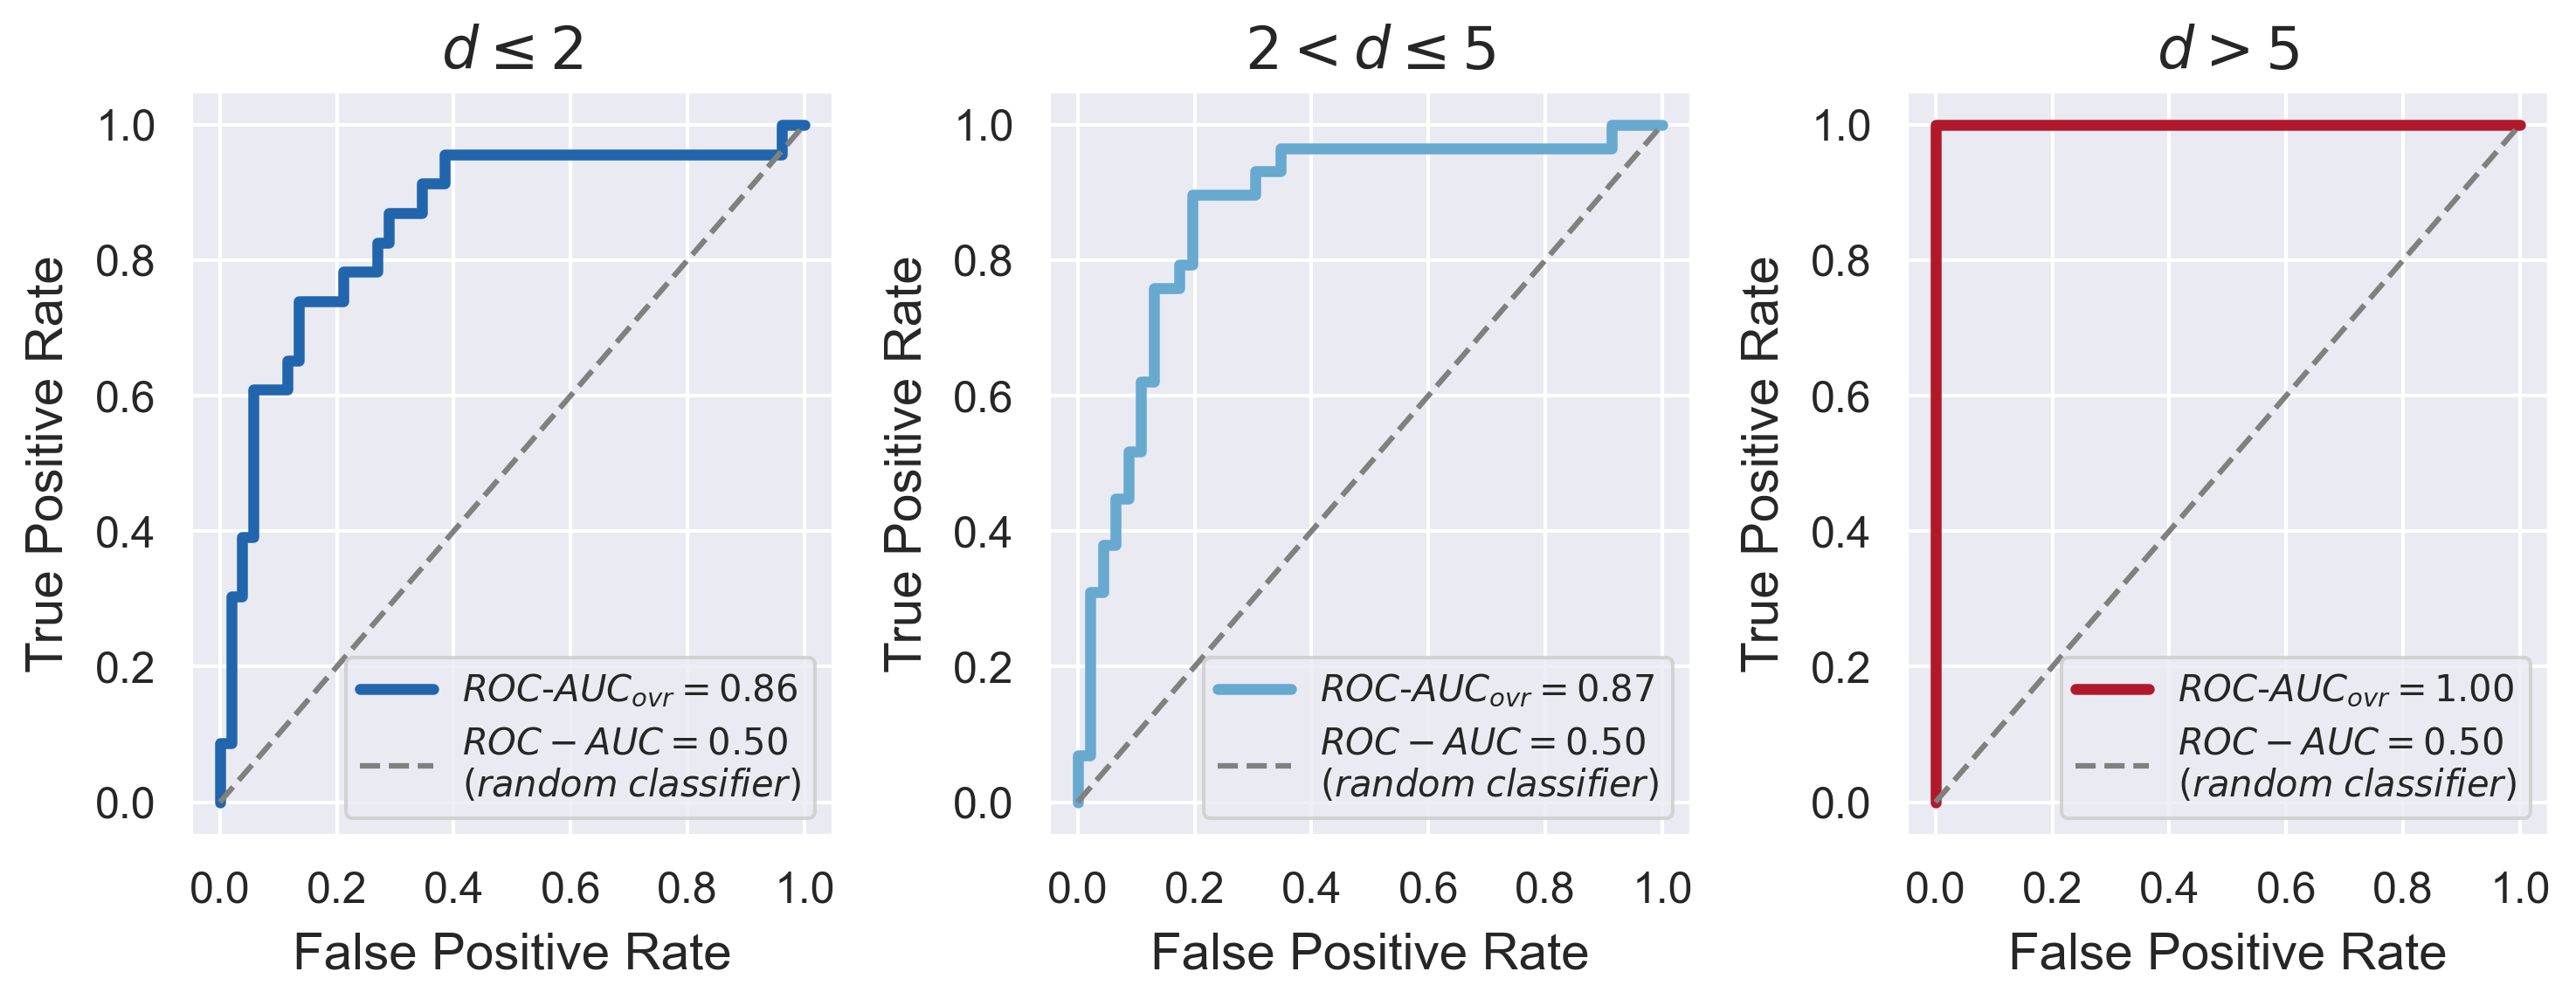

In [67]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X_scaled=X_scaled,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range_}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [68]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

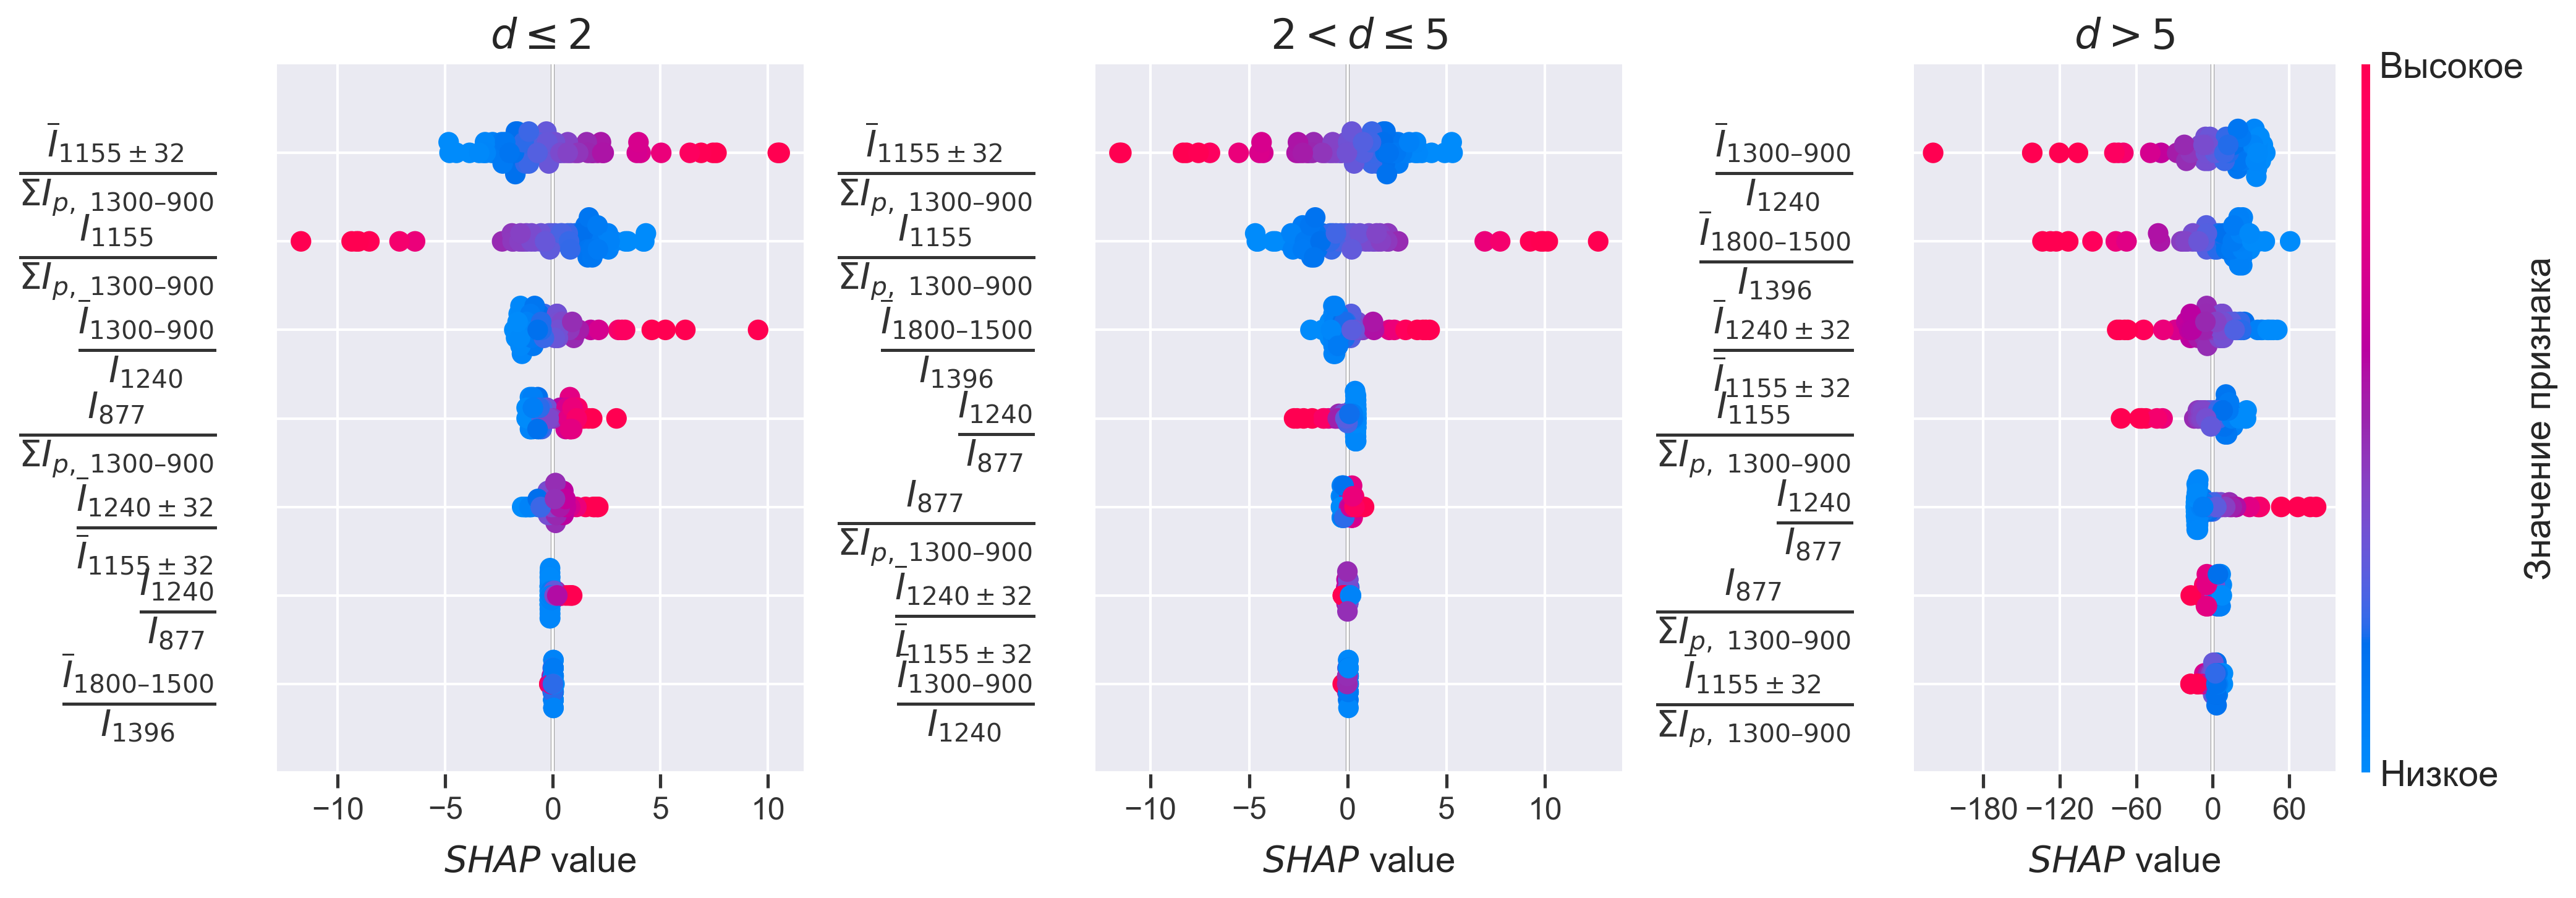

In [69]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):    
    show_colorbar = True if i == 2 else False

    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title
    
    plot_shap_summary_logreg(
        model=model,
        X_scaled=X_scaled,
        features_lst=X_scaled.columns.tolist(),
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/shap_3_subplots_{range_}.png', dpi=600)

plt.show()

#### *Feature importance* diagram

In [70]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Значимость признака (доля веса), %',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_NBINS': 20,
    'PALETTE': 'crest'
}

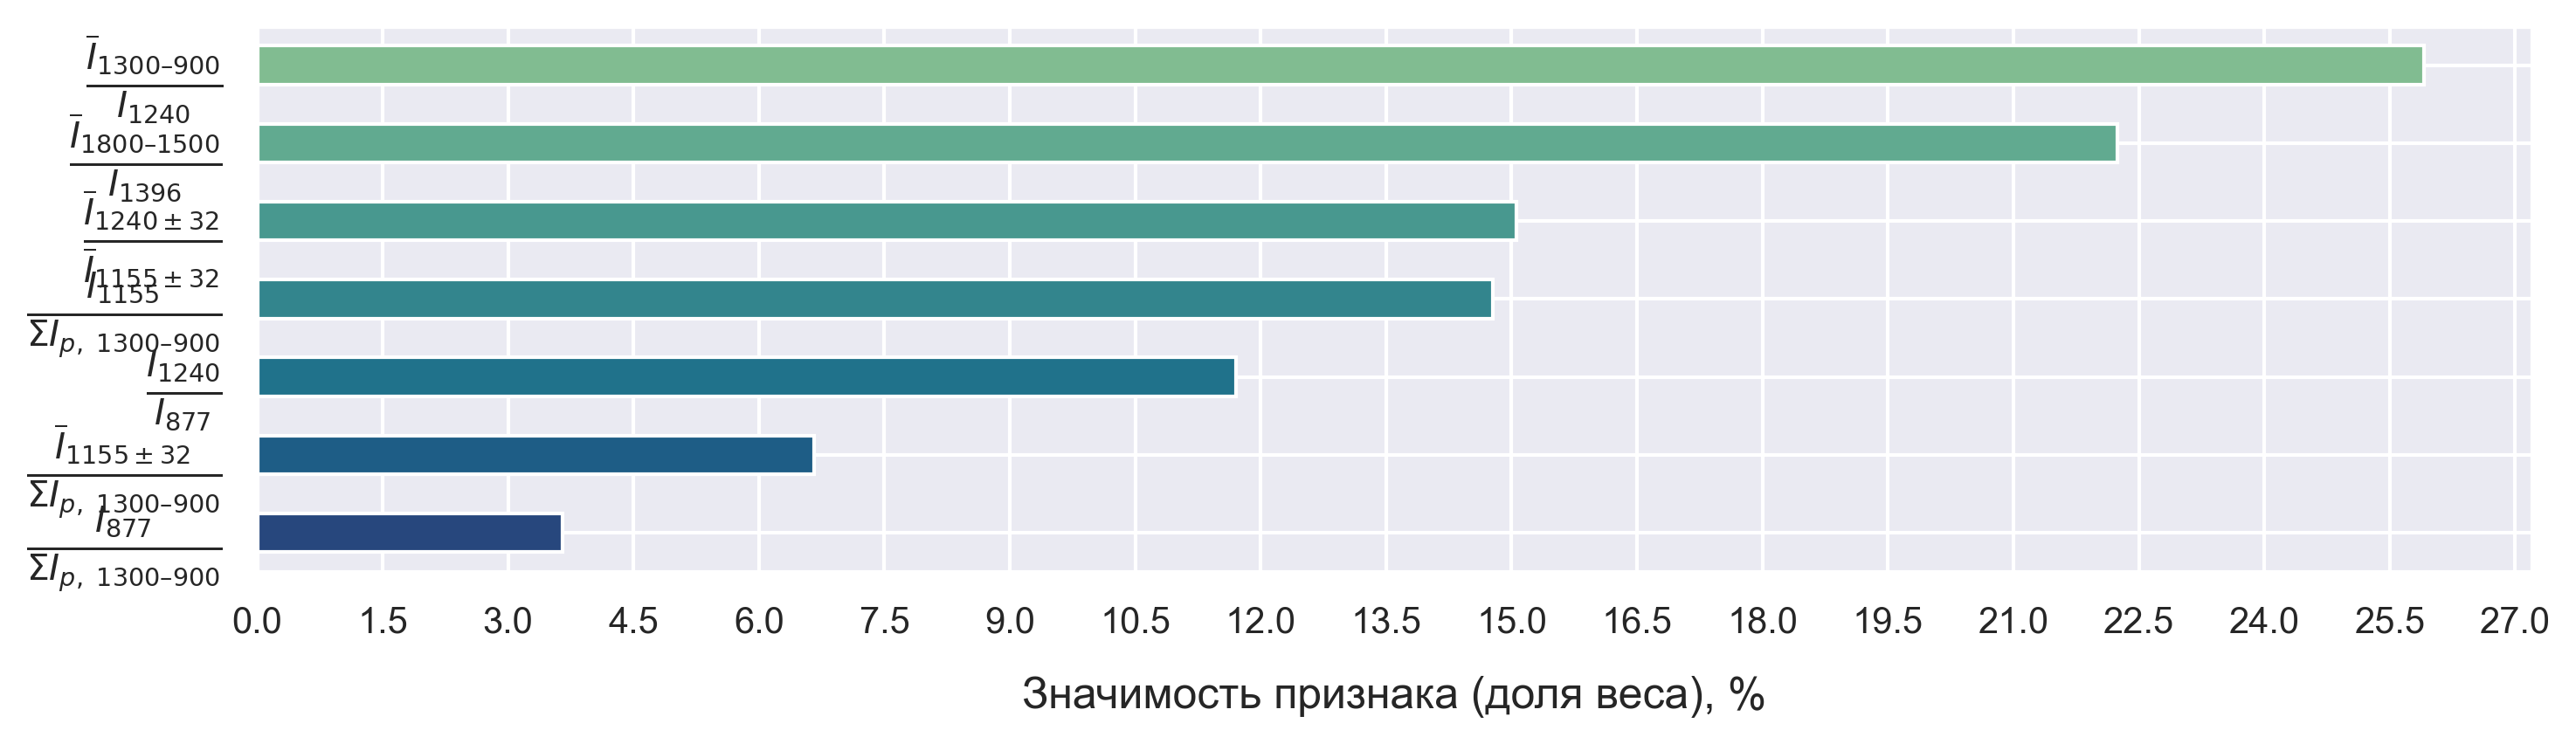

In [71]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_feature_importance_logreg(
    model=model,
    features_lst=X_scaled.columns.tolist(),
    max_display=15,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fi_barplot_{range_}.png', dpi=600)

plt.show()

### `3800-2500 x 1900-800` cm$^{-1}$

In [72]:
range_ = '3800_2500_1900_800'

#### Model fitting

In [73]:
model, X_scaled, scaler_df, coef_df, metrics_df, best_C_full, c_metric_df = logreg_full_bootstrap_cv_analysis(
    df=features_df,
    feature_list=selected_feats_3800_2500_1900_800,
    target=target,
    cv_folds=5,
    random_state=42,
    C_values=None,
    n_bootstrap=50
)

print(X_scaled.shape)
X_scaled.head(3)

Bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

CV:   0%|          | 0/5 [00:00<?, ?it/s]

(75, 5)


,$\frac{I_{3375}}{I_{2928}}$,$\frac{I_{1240}}{I_{877}}$,$\frac{\overline{I}_{1800\text{–}1500}}{\overline{I}_{1396 \pm 32}}$,"$\frac{I_{1155}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{3375 \pm 32}}{\Sigma I_{p,\ 3800\text{–}2500}}$"
0,0.939194,0.356705,-0.017662,-0.619484,0.902975
1,1.467786,-0.212010,0.040380,-0.324956,1.222435
2,0.506067,-0.353422,0.254771,-0.029465,0.813527


*Parameters for scaling*

In [74]:
display(scaler_df.T)

,0,1,2,3,4
Feature,$\frac{I_{3375}}{I_{2928}}$,$\frac{I_{1240}}{I_{877}}$,$\frac{\overline{I}_{1800\text{–}1500}}{\overline{I}_{1396 \pm 32}}$,"$\frac{I_{1155}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{3375 \pm 32}}{\Sigma I_{p,\ 3800\text{–}2500}}$"
Mean,1.174717,6.323723,0.745716,0.359016,0.304048
Std,0.87388,8.293259,0.295623,0.104572,0.100356


*Model parameters (weights & intercept)*

In [75]:
display(coef_df)

,$\frac{I_{3375}}{I_{2928}}$,$\frac{I_{1240}}{I_{877}}$,$\frac{\overline{I}_{1800\text{–}1500}}{\overline{I}_{1396 \pm 32}}$,"$\frac{I_{1155}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{3375 \pm 32}}{\Sigma I_{p,\ 3800\text{–}2500}}$",Intercept
Class 0,-8.332309,0.905192,-1.043026,-0.684969,1.160747,-4.459208
Class 1,-2.674730,-1.106416,1.254604,0.828488,3.563414,-0.811149
Class 2,-21.131778,52.235657,-31.070845,-45.944257,90.045417,-99.680307


*Model metrics*

In [76]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Train (CV mean),0.950222,0.914759
Test (CV mean),0.87084,0.807775
Bootstrap CI (5-95),"[0.9228, 0.9861]","[0.8782, 0.9721]"
$all$ $sample$,0.943634,0.9059


*Optimal inverse of regulation strength value*

#### Visualization of `C` optimization

In [77]:
print(f'Optimal value of regularization coefficient (C): {round(best_C_full, 4)}')

Optimal value of regularization coefficient (C): 10000.0


In [78]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3.3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Обратный коэффициент регуляризации ($C$)',
    'Y_LABEL': '$ROC-AUC_{ovr}$',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 11
}

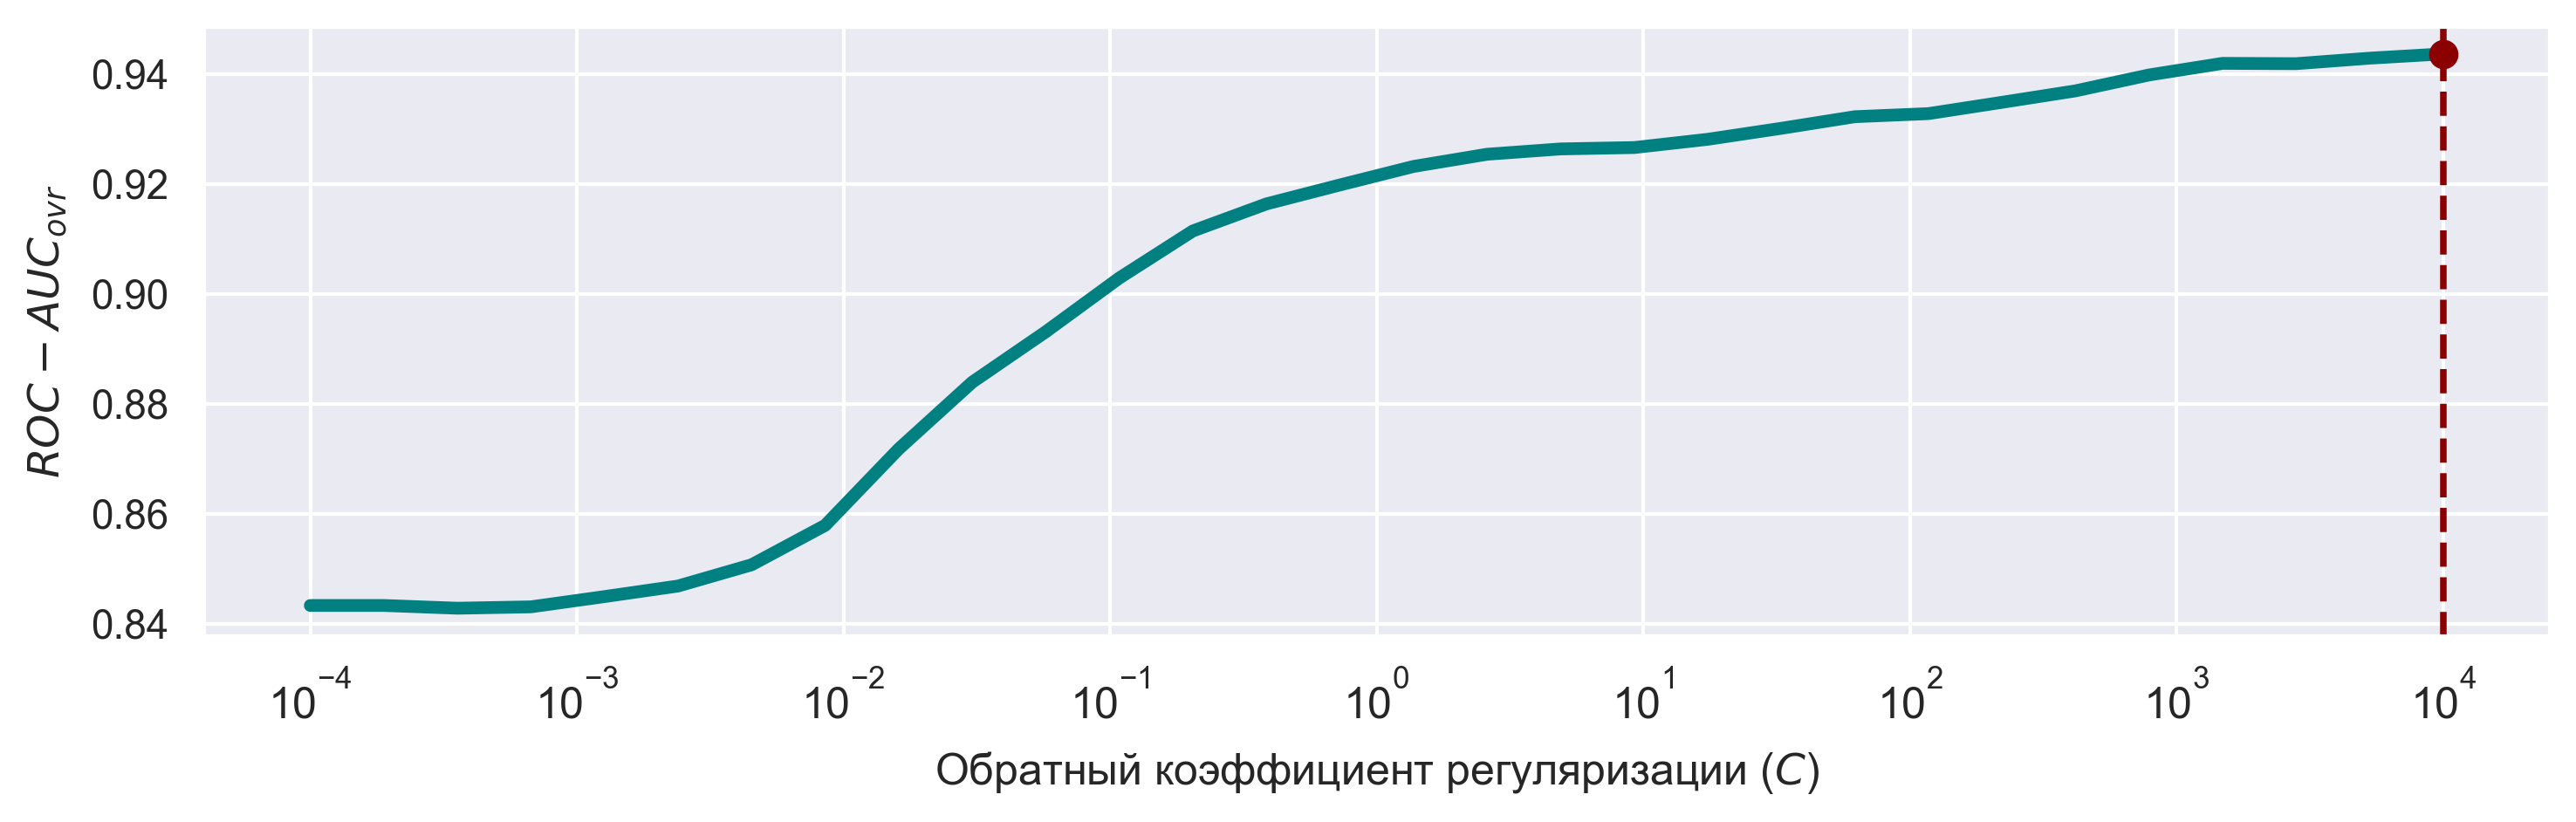

In [79]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_c_metric_curve(
    c_metric_df=c_metric_df,
    metric_name='roc_auc',
    best_C=best_C_full,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/c_optimization_curve_{range_}.png', dpi=600)

plt.show()

#### *ROC*-curves visualization

In [80]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

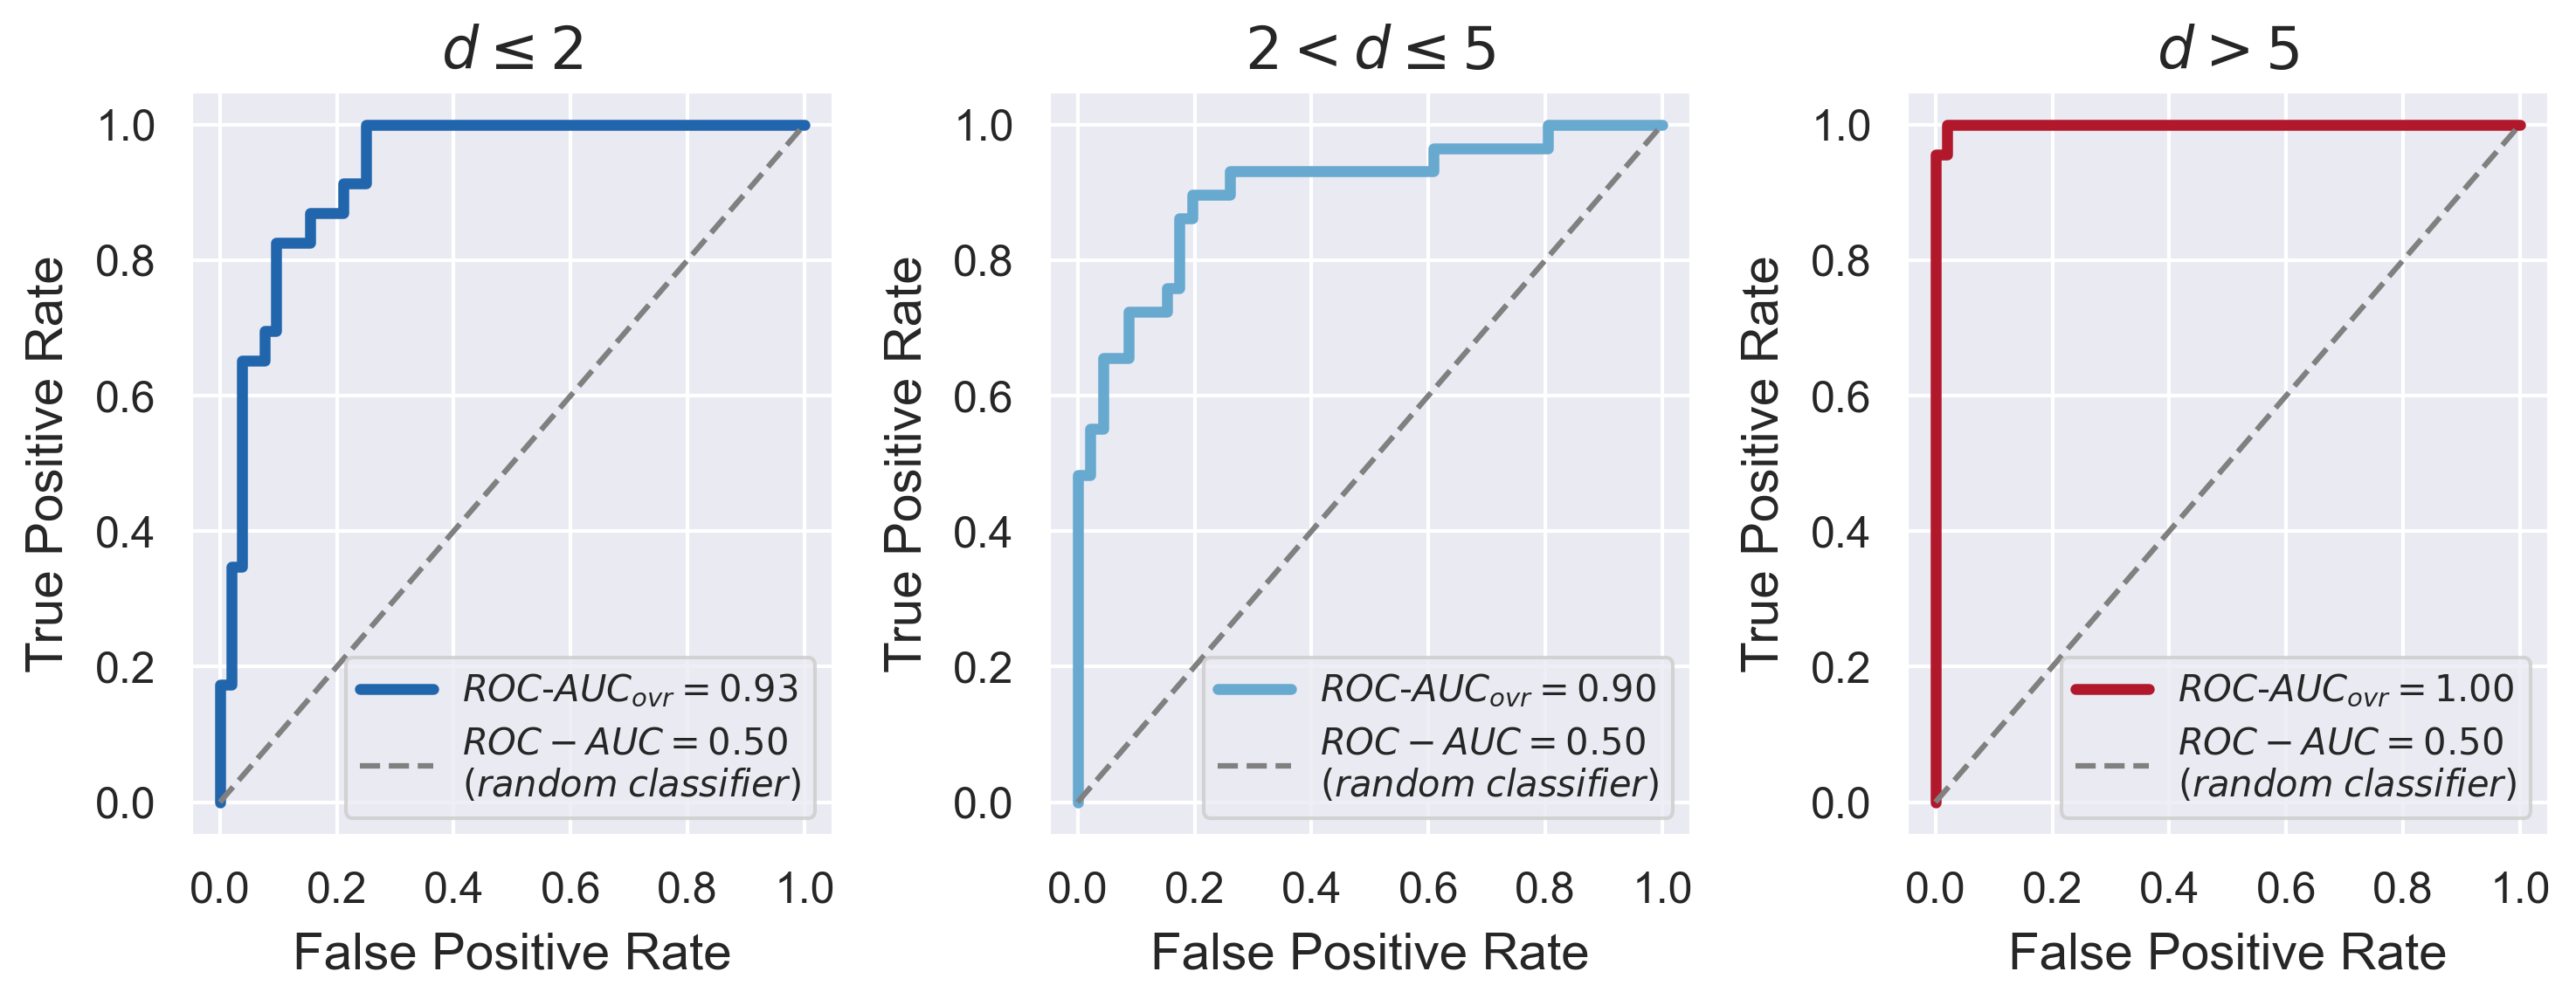

In [81]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X_scaled=X_scaled,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range_}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [82]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

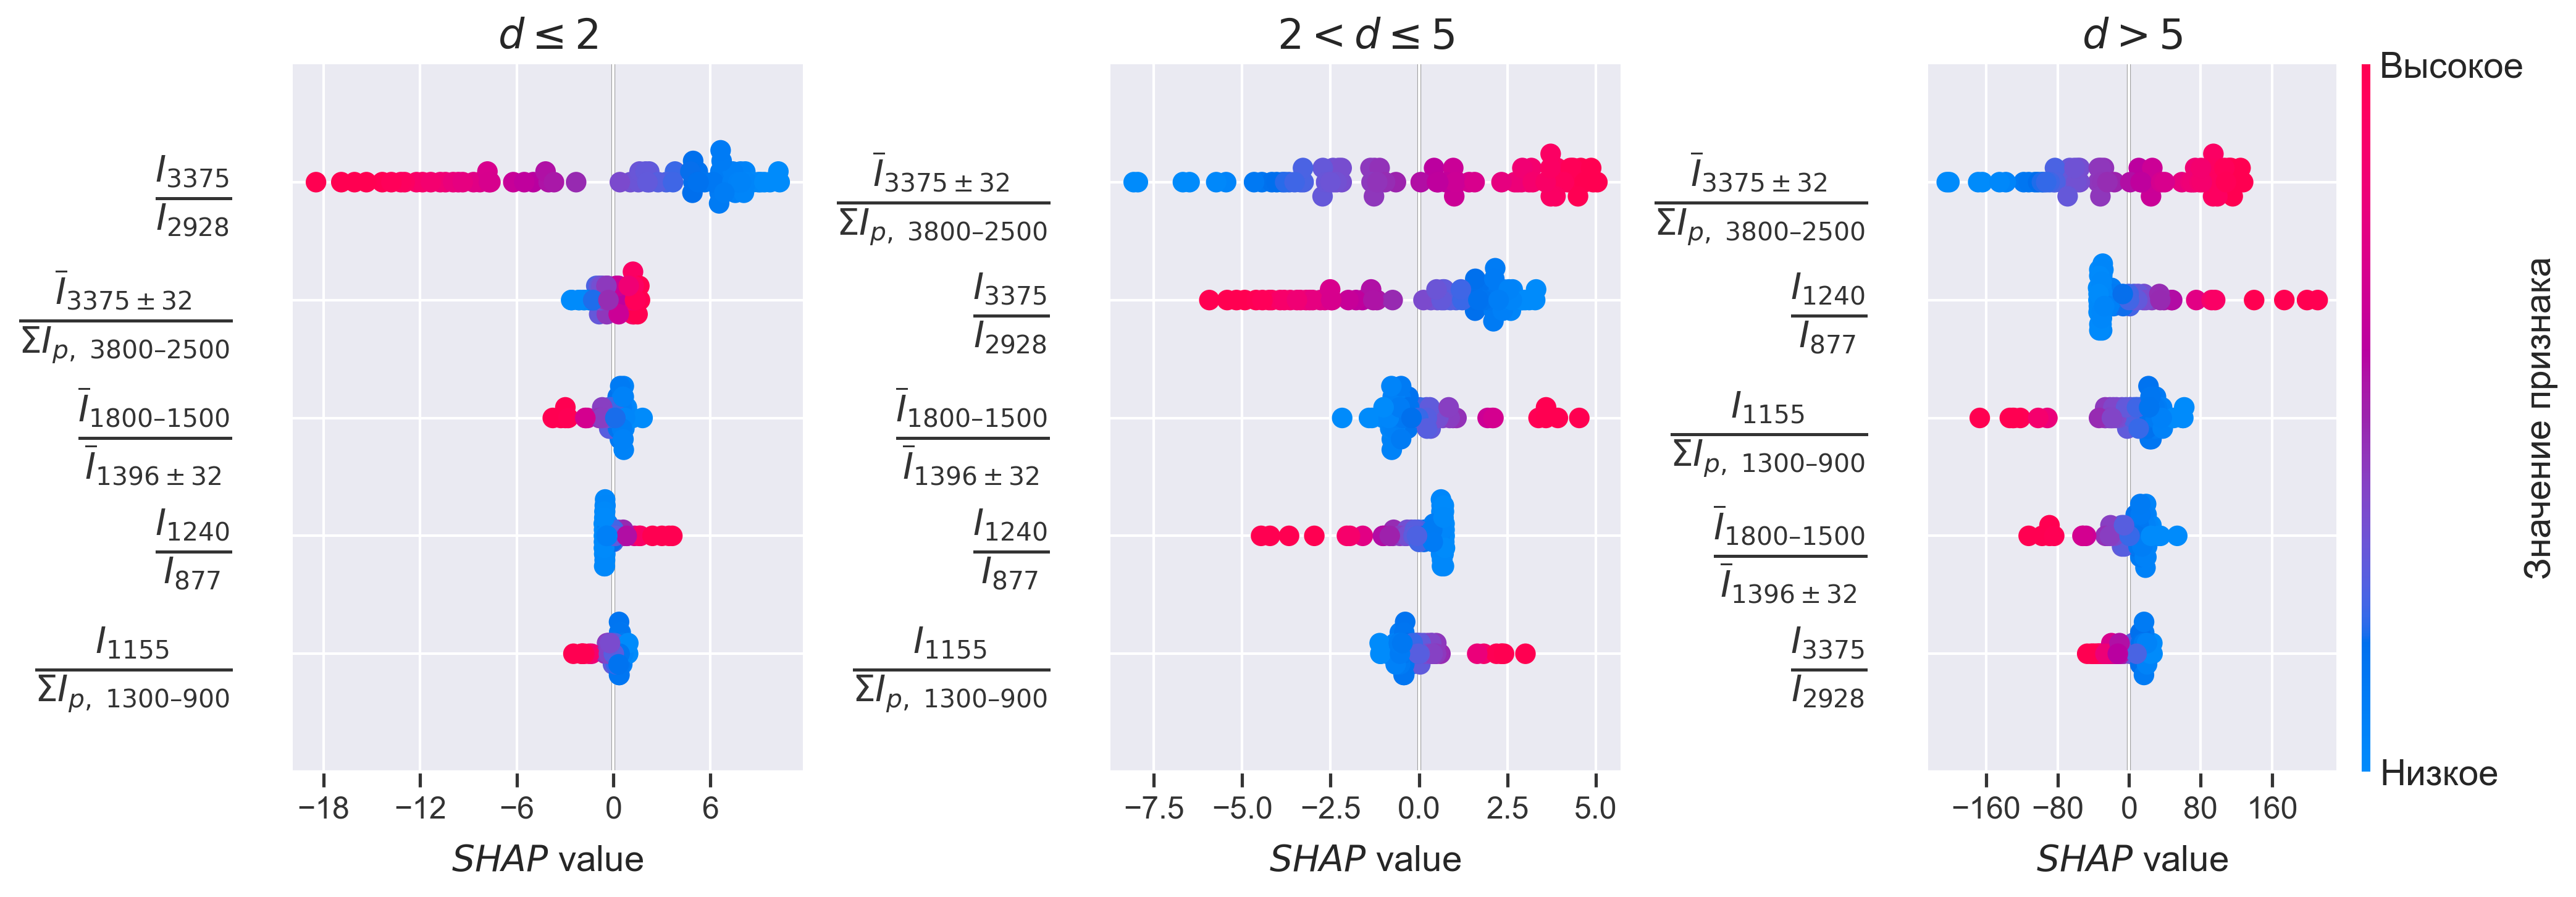

In [83]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):    
    show_colorbar = True if i == 2 else False

    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title
    
    plot_shap_summary_logreg(
        model=model,
        X_scaled=X_scaled,
        features_lst=X_scaled.columns.tolist(),
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/shap_3_subplots_{range_}.png', dpi=600)

plt.show()

#### *Feature importance* diagram

In [84]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Значимость признака (доля веса), %',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_NBINS': 20,
    'PALETTE': 'crest'
}

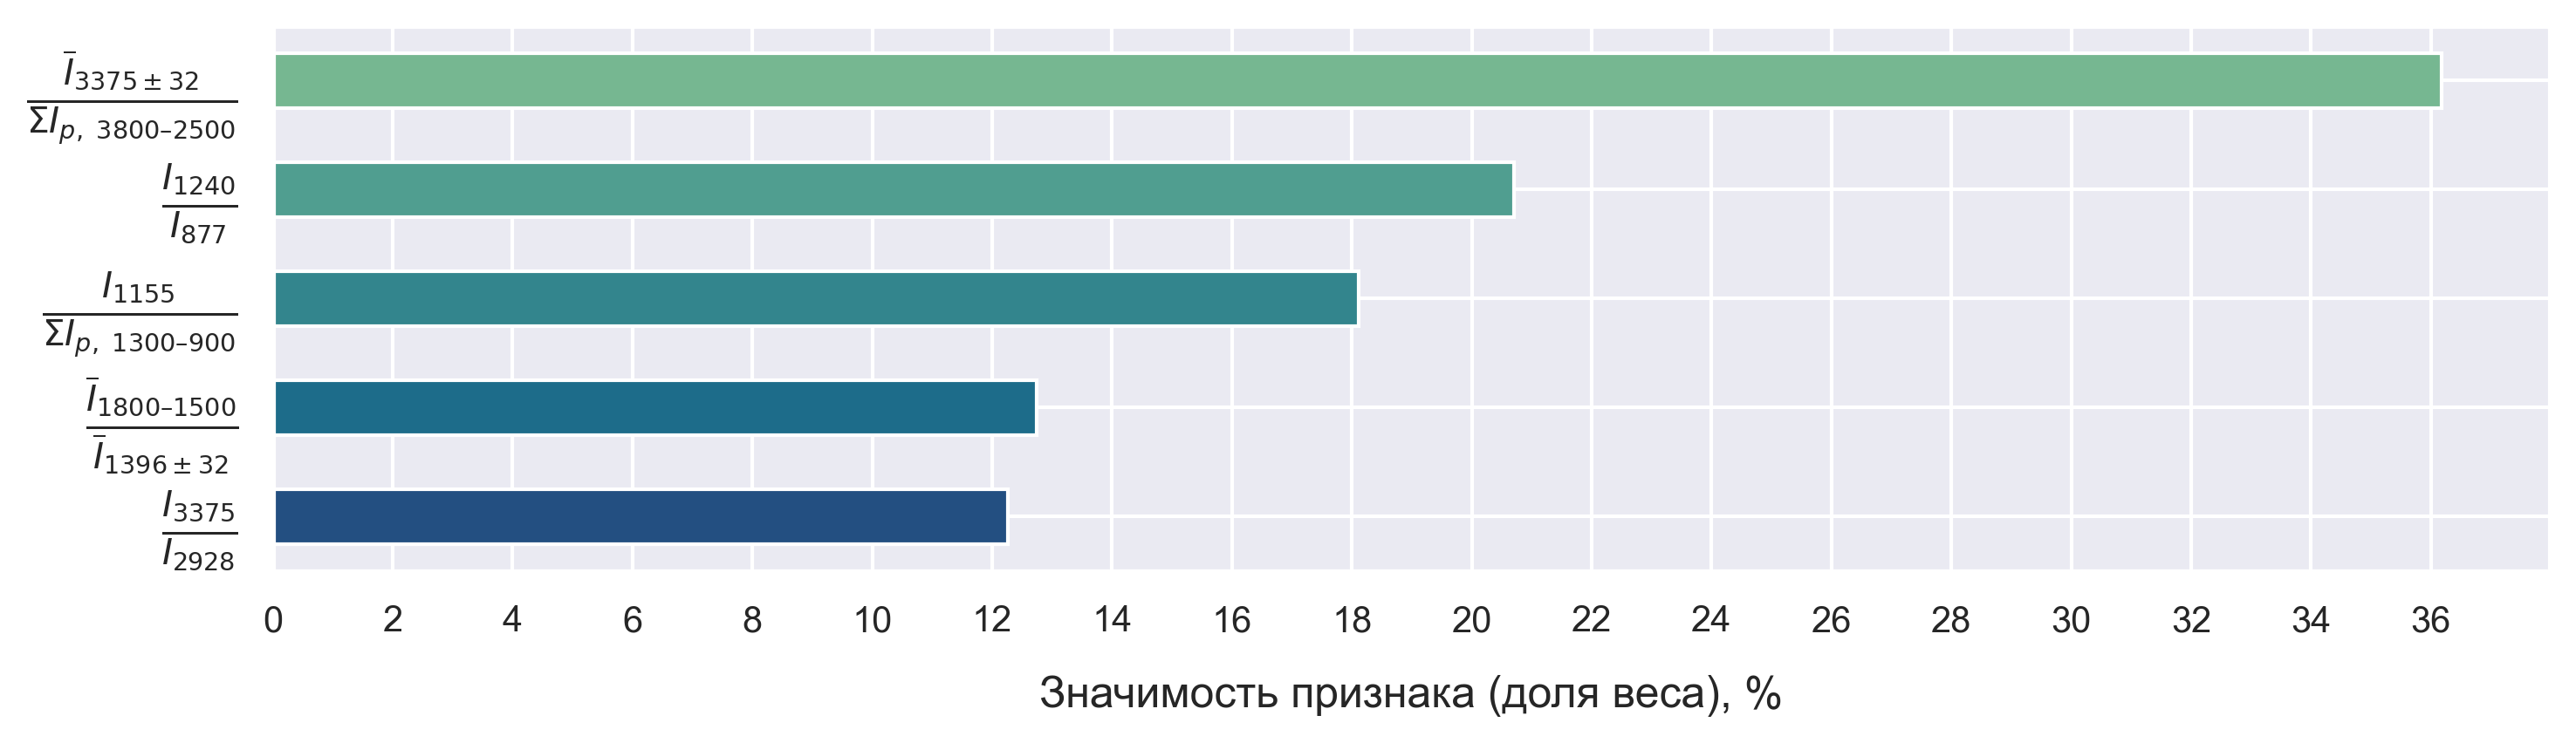

In [85]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

plot_feature_importance_logreg(
    model=model,
    features_lst=X_scaled.columns.tolist(),
    max_display=15,
    ax=ax
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/fi_barplot_{range_}.png', dpi=600)

plt.show()